# Initial Data Exploration and Analysis
---
This notebook will document the initial data exploration process. The goal is to do some basic visualisations and data exploration in order to identify any potential data quality issues. Any issues found will need to be investigated and an appropriate method to deal with these issues will be decided upon. The final dataframe will then be saved after cleaning and used for predictive modelling.

**The Goal:** The end goal is to create a machine learning model which can predict the busyness of a particular area in Manhattan. Throughout the analysis, consideration will be given towards this overarching goals when deciding which features to keep.

## Data Dictionary
---
Below is the data dictionary as provided by TLC. This is what we will be using to analyse each feature.

The official data dictionary can be found here: https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

|Field Name|Description|Code Definitions|
|-----------|-----------|---------------|
|**VendorID**|A code indicating the TPEP provider that provided the record. |1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.|
|**tpep_pickup_datetime**|The date and time when the meter was engaged.||
|**tpep_dropoff_datetime**|The date and time when the meter was disengaged. ||
|**Passneger_count**|The number of passengers in the vehicle. This is a driver-entered value, and might not accurately reflect the number of passengers on a trip.||
|**PULocationID**|TLC Taxi Zone in which the taximeter was engaged|corresponds with location_id field in NYC Taxi Zones https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc||
|**DOLocationID**|TLC Taxi Zone in which the taximeter was disengaged|corresponds with location_id field in NYC Taxi Zones https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc||
|**RateCodeID**|The final rate code in effect at the end of the trip.|1= Standard rate, 2=JFK, 3=Newark, 4=Nassau or Westchester, 5=Negotiated fare, 6=Group ride|
|**Store_and_fwd_flag**|This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. |Y= store and forward trip N= not a store and forward trip|
|**Payment_Type**|A numeric code signifying how the passenger paid for the trip. |1= Credit card 2= Cash 3= No charge 4= Dispute 5= Unknown 6= Voided trip|
|**Fare_amount**|The time-and-distance fare calculated by the meter.||
|**Extra**|Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 rush hour and overnight charges.|
|**MTA_tax**|0.50 MTA tax that is automatically triggered based on the metered rate in use.|
|**Improvement_surcharge**|0.30 improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.|
|**Tip_amount**|Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.|
|**Tolls_amount**|Total amount of all tolls paid in trip. |
|**Total_amount**|The total amount charged to passengers. Does not include cash tips.|
|**congestion_surcharge**|Total amount collected in trip for NYS congestion surcharge.|
|**airport_fee**|1.25 for pick up only at LaGuardia and John F. Kennedy Airports|

## Loading in the Datasets
--- 

Before any analysis, we simply load in any necessary modules, as well as the datasets. 

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import calendar
import contextily as ctx
import glob

In [2]:
# Using glob to load in all the parquet files
data_files = glob.glob('Yellow_Taxi_Tripdata/2022/' + '*.parquet') 
data_files = sorted(data_files)

data_files

['Yellow_Taxi_Tripdata/2022/yellow_tripdata_2022-01.parquet',
 'Yellow_Taxi_Tripdata/2022/yellow_tripdata_2022-02.parquet',
 'Yellow_Taxi_Tripdata/2022/yellow_tripdata_2022-03.parquet',
 'Yellow_Taxi_Tripdata/2022/yellow_tripdata_2022-04.parquet',
 'Yellow_Taxi_Tripdata/2022/yellow_tripdata_2022-05.parquet',
 'Yellow_Taxi_Tripdata/2022/yellow_tripdata_2022-06.parquet',
 'Yellow_Taxi_Tripdata/2022/yellow_tripdata_2022-07.parquet',
 'Yellow_Taxi_Tripdata/2022/yellow_tripdata_2022-08.parquet',
 'Yellow_Taxi_Tripdata/2022/yellow_tripdata_2022-09.parquet',
 'Yellow_Taxi_Tripdata/2022/yellow_tripdata_2022-10.parquet',
 'Yellow_Taxi_Tripdata/2022/yellow_tripdata_2022-11.parquet',
 'Yellow_Taxi_Tripdata/2022/yellow_tripdata_2022-12.parquet']

In [3]:
# List to store each month in a dataframe
dataframes = []

for file in data_files:
    df = pd.read_parquet(file)
    dataframes.append(df)

In [4]:
# Concantenating all 12 months into one dataframe
df = pd.concat(dataframes)

Since we are working solely within Manhattan, we load in the taxi zone lookup data, and use that to filter our data frame in to include only rows which correspong to zones withing the Manhattan Borough.

In [5]:
taxi_zones = pd.read_csv("NYC_Taxi_Zones/taxi_zone_lookup.csv")
taxi_zones

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NV,NaN


In [6]:
manhattan_zones = taxi_zones[taxi_zones['Borough'] == 'Manhattan']
manhattan_zones

,LocationID,Borough,Zone,service_zone
3,4,Manhattan,Alphabet City,Yellow Zone
11,12,Manhattan,Battery Park,Yellow Zone
12,13,Manhattan,Battery Park City,Yellow Zone
23,24,Manhattan,Bloomingdale,Yellow Zone
40,41,Manhattan,Central Harlem,Boro Zone
...,...,...,...,...
245,246,Manhattan,West Chelsea/Hudson Yards,Yellow Zone
248,249,Manhattan,West Village,Yellow Zone
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone


In [7]:
# Removing all rows where Pickup or dropoff is outside of Manhattan
df = df[df['PULocationID'].isin(manhattan_zones['LocationID'])]
df = df[df['DOLocationID'].isin(manhattan_zones['LocationID'])]

## Initial Data Exploration
--- 

Our resulting dataframe is now limited to manhatattan, and contains all 2022 trip records. Now we can begin the initial data exploration, and try identify any potential quality issues.

In [8]:
df.shape

(32716753, 19)

The dataframe has 32,716,753 rows, and 19 columns.

In [9]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [10]:
df.tail()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
3399540,2,2022-12-31 23:01:46,2022-12-31 23:26:45,NaN,3.97,NaN,None,107,50,0,23.55,0.0,0.5,5.51,0.0,1.0,33.06,NaN,NaN
3399542,2,2022-12-31 23:06:51,2022-12-31 23:17:08,NaN,0.91,NaN,None,68,48,0,17.65,0.0,0.5,4.33,0.0,1.0,25.98,NaN,NaN
3399543,2,2022-12-31 23:16:37,2022-12-31 23:34:19,NaN,7.50,NaN,None,263,261,0,33.63,0.0,0.5,3.76,0.0,1.0,41.39,NaN,NaN
3399545,2,2022-12-31 23:13:24,2022-12-31 23:29:08,NaN,5.06,NaN,None,75,50,0,26.23,0.0,0.5,0.00,0.0,1.0,30.23,NaN,NaN
3399547,1,2022-12-31 23:02:50,2022-12-31 23:16:05,NaN,0.00,NaN,None,238,116,0,12.74,0.0,0.5,0.00,0.0,1.0,16.74,NaN,NaN


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32716753 entries, 0 to 3399547
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee          

From analysing the data dictionary, this dataset contains 2 datetime features, 8 categorical features, and the remaining 9 features are continuous. 
<br><br>
We will now create new dataframes for both categorical and continuous features. This will help later when plotting and analysing features.
<br><br>
**Note:** While PULocationID and DOLocationID are categorical, they are being kept separate. Due to high cardinality, they will need to be dealt with differently.

In [12]:
# Creating new dataframes for analysis
categorical_columns = df[['VendorID', 'passenger_count', 'RatecodeID', 'store_and_fwd_flag', 'payment_type',
                         'mta_tax']]
continuous_columns = df[['trip_distance', 'fare_amount', 'extra', 'tip_amount', 'tolls_amount',
                        'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']]
zones = df[['PULocationID', 'DOLocationID']]

For now, we will keep the data types as they are. However, due to the size of the dataset itself, memory usage is quite high. We may need to investigate methods to reduce memory load if this proves troublesome down the line. Currently, we leave data types as is, as many of the categorical features are numeric, and we want to be able to perform comparison operations for data testing, which we cannot do with the "category" data type. We can instead convert the datatypes in our new categorical_columns to category, and keep the original as is.

### Checking for duplicate rows & columns

In [13]:
print('Number of duplicate (excluding first) rows in the table is: ', df.duplicated().sum())

Number of duplicate (excluding first) rows in the table is:  0


### Checking for constant columns

In [14]:
categorical_columns = categorical_columns.astype('category')
categorical_columns.describe().T

,count,unique,top,freq
VendorID,32716753,3,2,23270071
passenger_count,31726704.0,10.0,1.0,23585980.0
RatecodeID,31726704.0,7.0,1.0,31550645.0
store_and_fwd_flag,31726704,2,N,31291608
payment_type,32716753,6,1,25158403
mta_tax,32716753.0,21.0,0.5,32418670.0


#### Categorical Columns - Initial Observations:
Reviewing the categorical data, we see all features have > 1 unique values.
- *VendorID* has 3 uniques values. There should only be 2.
- *passenger_count* has 10 unique values. This seems implausible as taxis have a maximum capacity. We will look into this further.
- *RatecodeID* has 7 unique values. Again, it should only have 6 according to the data dictionary.
- *store_and_fwd_flag* has 2 unique values and seems correct.
- *payment_type* has 6 unique values. This seems correct.
- *mta_tax* has 21 unique values. Again, this will need to be investigated as it should not be this high.

In [15]:
continuous_columns.describe().T

,count,mean,std,min,25%,50%,75%,max
trip_distance,32716753.0,3.986663,541.700302,0.000000e+00,1.02,1.62,2.59,3.896785e+05
fare_amount,32716753.0,5.092638,24582.465068,-1.333914e+08,6.50,9.00,13.00,4.010923e+05
extra,32716753.0,1.017599,1.202510,-2.218000e+01,0.00,0.50,2.50,2.800000e+01
tip_amount,32716753.0,7.551196,24582.233950,-4.100000e+02,1.00,2.06,3.00,1.333914e+08
tolls_amount,32716753.0,0.007652,0.354281,-5.400000e+01,0.00,0.00,0.00,9.118700e+02
improvement_surcharge,32716753.0,0.316173,0.126963,-1.000000e+00,0.30,0.30,0.30,1.000000e+00
total_amount,32716753.0,16.218586,104.320352,-8.003000e+02,11.76,14.76,19.03,4.010956e+05
congestion_surcharge,31726704.0,2.419571,0.516211,-2.500000e+00,2.50,2.50,2.50,2.750000e+00
airport_fee,31726704.0,0.000464,0.025131,-1.250000e+00,0.00,0.00,0.00,1.250000e+00


#### Continuous Columns - Initial Observations:
- All standard deviations are non zero, this implies there are no constant columns.
- Some extreme outliers appear to be present. For example, in trip_distance and tip_amount, we see extremely high max values and standard deviations. These will be investigated further.
- Some negative values which look to be erroneous. Logically, things like trip distance, tips, and total fare seem implausible as negative values.

To further investigate these negative values, we will do a simple count first. We will check all columns, as categorical features are also numeric.

In [16]:
negative_counts = {}

# Iterate over each column in the DataFrame
for column in df.columns:
    # Check if the values in the column are numeric
    if pd.api.types.is_numeric_dtype(df[column]):
        # Count the number of negative values in the column
        negative_count = df[column].lt(0).sum()
        # Store the column name and corresponding count in the dictionary
        negative_counts[column] = negative_count

# Print the column names and the corresponding counts of negative values
for column, count in negative_counts.items():
    print(f"Column '{column}' has {count} negative value(s).")

Column 'VendorID' has 0 negative value(s).
Column 'passenger_count' has 0 negative value(s).
Column 'trip_distance' has 0 negative value(s).
Column 'RatecodeID' has 0 negative value(s).
Column 'PULocationID' has 0 negative value(s).
Column 'DOLocationID' has 0 negative value(s).
Column 'payment_type' has 0 negative value(s).
Column 'fare_amount' has 189950 negative value(s).
Column 'extra' has 90704 negative value(s).
Column 'mta_tax' has 187454 negative value(s).
Column 'tip_amount' has 411 negative value(s).
Column 'tolls_amount' has 576 negative value(s).
Column 'improvement_surcharge' has 191116 negative value(s).
Column 'total_amount' has 191658 negative value(s).
Column 'congestion_surcharge' has 182436 negative value(s).
Column 'airport_fee' has 520 negative value(s).


There appears to be quite a large number of negative values which don't make sense in the context of the features. These will need to be investigated further, and a solution for dealing with them settled on.

### Checking for null values

In [17]:
df.isnull().sum()

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          990049
trip_distance                 0
RatecodeID               990049
store_and_fwd_flag       990049
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     990049
airport_fee              990049
dtype: int64

In [18]:
# Prepare %missing column (from lab)
missing  = 100 * (df.isnull().sum()/df.shape[0])

# store the values in a dataframe
missing = pd.DataFrame(missing, columns=['% missing'])
missing

,% missing
VendorID,0.000000
tpep_pickup_datetime,0.000000
tpep_dropoff_datetime,0.000000
passenger_count,3.026122
trip_distance,0.000000
RatecodeID,3.026122
store_and_fwd_flag,3.026122
PULocationID,0.000000
DOLocationID,0.000000
payment_type,0.000000


**Result:** There does appear to be missing values. However, they only account for around 3.03% of the rows. We will identify a plan for dealing with these further in the analysis.

In [19]:
print("\033[1m" + "Unique values for:" + "\033[0m")
for column in categorical_columns:
    print("\n" + "\033[1m" + column + "\033[0m \n", pd.unique(df[column].ravel()))
for column in zones:
    print("\n" + "\033[1m" + column + "\033[0m \n", pd.unique(df[column].ravel()))

Unique values for:

VendorID 
 [1 2 5]

passenger_count 
 [ 2.  1.  3.  4.  5.  6.  0.  7.  8.  9. nan]

RatecodeID 
 [ 1.  5.  2.  3. 99.  4.  6. nan]

store_and_fwd_flag 
 ['N' 'Y' None]

payment_type 
 [1 2 4 3 5 0]

mta_tax 
 [ 0.5   0.   -0.5   0.35  3.3   0.32  3.    2.8   0.05 17.1   2.78  2.54
  2.55 25.48  2.24  0.8   1.5   1.3   0.3   4.    1.  ]

PULocationID 
 [142 236 166 114  68 233 238 141 234 246  43 239 148 237 107 263 161  79
 170 162   4 262 249 137  90  45  48 211 113 164  50  88 186 144 224  24
 158  74 140 163 229 209 232 151 231  75  87 116  13  41 261 125  42 152
 143 243 244  12 230 100 202 127 194 120 153 128 105]

DOLocationID 
 [236  42 166  68 163  87 152 141 229  90 113  79 140 151 107 263 161  43
  24 233 238 237 249 186 262  74   4  45  48 142 170 137 261 246  41 239
 148 243 153 231 114 211 164 144  13 125  50 162 234 202 224 244 158 232
  88  75 127 143 116 100 209 120 230 194  12 128 105]


### Descriptive Statistics: Continuous Features

In [20]:
for feature in continuous_columns:
    print("\033[1m" + feature + "\033[0m")
    print("----------")
    print("Range {} is: ".format(feature), (df[feature].max() - df[feature].min()))
    print("----------")
    print('{0:.5}  {1}'.format("Value", "Number of Instances"))
    print(df[feature].value_counts().nlargest(15), "\n\n\n")

trip_distance
----------
Range trip_distance is:  389678.46
----------
Value  Number of Instances
1.0    542864
0.9    535556
1.1    532157
1.2    521384
0.8    512924
1.3    503716
1.4    482760
0.7    464861
1.5    458178
1.6    436921
1.7    409923
0.6    392512
1.8    382365
1.9    355219
2.0    329984
Name: trip_distance, dtype: int64 



fare_amount
----------
Range fare_amount is:  133792506.32
----------
Value  Number of Instances
6.5     1683811
7.0     1652196
7.5     1616428
6.0     1604501
8.0     1574074
8.5     1497352
5.5     1491658
9.0     1423872
9.5     1327657
5.0     1305892
10.0    1300589
10.5    1130078
11.0    1043814
4.5     1001981
11.5     945421
Name: fare_amount, dtype: int64 



extra
----------
Range extra is:  50.18
----------
Value  Number of Instances
 0.0    13081767
 0.5     5857226
 2.5     5094229
 1.0     4552194
 3.0     2168478
 3.5     1807428
-0.5       54353
 5.0       52623
-1.0       32810
 4.5        9027
-4.5        1946
-2.5        1490

- Again, some of these ranges seem highly implasuible, likely due to the extreme outliers previously mentioned. These will need to be examined and dealt with.
- Also of note, it appears some values for airport_fee are non-null which is interesting. As we have filtered for only pickups and dropoffs withing Manhattan, there should be no trips to the aiport.

### Logical Integrity Testing

We want to run some basic tests to quickly identify any illogical or erroneous data entries. Once identified, the team will decide the best approach to dealing with these data quality issues and provide a data quality plan.

**Test 1:** Checking if all pickup and dropoff zones are valid and within new york. The zones range from 1-263, so we check to see if any location IDs fall outside this range.

In [22]:
invalid_pu_locs = df[(df['PULocationID'] < 1) | (df['PULocationID'] > 263)]
invalid_do_locs = df[(df['DOLocationID'] < 1) | (df['DOLocationID'] > 263)]

if len(invalid_pu_locs) > 0 or len(invalid_do_locs) > 0:
    print("There are invalid values in either PULocationID or DOLocationID.")
    if len(invalid_pu_locs) > 0:
        print("Invalid PULocationID values:")
        print(invalid_pu_locs['PULocationID'].unique())
    if len(invalid_do_locs) > 0:
        print("Invalid DOLocationID values:")
        print(invalid_do_locs['DOLocationID'].unique())
else:
    print("All values in PULocationID and DOLocationID are within the valid range.")

All values in PULocationID and DOLocationID are within the valid range.


**Test 2:** Are there any trips with more than 6 passengers?

As per the official TLC website - "The maximum amount of passengers allowed in a yellow taxicab by law is four (4) in a four (4) passenger taxicab or five (5) passengers in a five (5) passenger taxicab, except that an additional passenger must be accepted if such passenger is under the age of seven (7) and is held on the lap of an adult passenger seated in the rear."

Link: https://www.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page#:~:text=The%20maximum%20amount%20of%20passengers,of%20an%20adult%20passenger%20seated

As such any more is unallowed by law and make illogical sense.

In [23]:
passenger_count_test = df[df['passenger_count'] > 6]
print('Number of rows failing the test ', passenger_count_test.shape[0])
passenger_count_test.head()

Number of rows failing the test  79


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,date,month,time,day_of_the_week
552779,2,2022-01-08 21:10:10,2022-01-08 21:10:12,7.0,0.00,5.0,N,249,249,1,...,17.58,0.0,0.3,87.88,0.0,0.0,2022-01-08,1,21,Saturday
911365,2,2022-01-13 18:19:04,2022-01-13 18:19:08,8.0,0.00,5.0,N,43,43,1,...,0.00,0.0,0.3,84.30,0.0,0.0,2022-01-13,1,18,Thursday
1164748,2,2022-01-16 17:10:14,2022-01-16 17:10:21,8.0,0.00,5.0,N,170,170,1,...,2.32,0.0,0.3,13.92,2.5,0.0,2022-01-16,1,17,Sunday
1183241,2,2022-01-16 23:43:38,2022-01-16 23:46:00,9.0,0.12,5.0,N,141,141,2,...,0.00,0.0,0.3,12.60,2.5,0.0,2022-01-16,1,23,Sunday
2112203,2,2022-01-27 21:04:49,2022-01-27 21:06:40,7.0,0.32,5.0,N,140,140,1,...,4.00,0.0,0.3,47.30,2.5,0.0,2022-01-27,1,21,Thursday


**Test 3:** Are all dates in 2022?

In [24]:
dates_before_or_after_2022 = df[(df['date'] < '2022-01-01') | (df['date'] > '2022-12-31')]
print('Number of rows failing the test ', dates_before_or_after_2022.shape[0])
dates_before_or_after_2022.head()

Number of rows failing the test  362


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,date,month,time,day_of_the_week
940,2,2021-12-31 23:52:28,2021-12-31 23:59:42,1.0,1.45,1.0,N,238,263,1,...,2.82,0.0,0.3,14.12,2.5,0.0,2021-12-31,12,23,Friday
1028,2,2021-12-31 23:59:23,2022-01-01 00:02:27,2.0,1.06,1.0,N,79,137,1,...,1.76,0.0,0.3,10.56,2.5,0.0,2021-12-31,12,23,Friday
1049,2,2021-12-31 23:57:54,2022-01-01 00:03:07,1.0,1.13,1.0,N,148,107,1,...,1.96,0.0,0.3,11.76,2.5,0.0,2021-12-31,12,23,Friday
1290,2,2021-12-31 23:57:35,2022-01-01 00:12:11,2.0,4.10,1.0,N,249,140,1,...,5.34,0.0,0.3,23.14,2.5,0.0,2021-12-31,12,23,Friday
1519,2,2021-12-31 23:18:41,2021-12-31 23:22:44,5.0,1.30,1.0,N,140,75,1,...,2.45,0.0,0.3,12.25,2.5,0.0,2021-12-31,12,23,Friday


**Test 4:** Are there any trips above 100 miles? 

Given we are looking solely at trips that begin and end in Manhattan, extreme distances seem unlikely given the size of the borough itself.

In [25]:
distance_test = df[df['trip_distance'] >= 100]
print('Number of rows failing the test ', distance_test.shape[0])
distance_test.head()

Number of rows failing the test  749


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,date,month,time,day_of_the_week
23729,1,2022-01-01 11:42:44,2022-01-01 12:00:40,3.0,179.6,1.0,N,263,144,1,...,4.15,0.0,0.3,24.95,2.5,0.0,2022-01-01,1,11,Saturday
71368,1,2022-01-02 10:59:53,2022-01-02 11:19:12,1.0,172.8,1.0,N,238,137,1,...,0.00,0.0,0.3,21.80,2.5,0.0,2022-01-02,1,10,Sunday
85751,1,2022-01-02 14:35:42,2022-01-02 14:52:48,1.0,120.2,1.0,N,230,24,1,...,5.00,0.0,0.3,23.30,2.5,0.0,2022-01-02,1,14,Sunday
99158,1,2022-01-02 17:19:52,2022-01-02 17:40:12,2.0,121.1,1.0,N,162,45,1,...,4.70,0.0,0.3,23.50,2.5,0.0,2022-01-02,1,17,Sunday
152821,1,2022-01-03 14:38:55,2022-01-03 15:06:21,3.0,196.9,1.0,N,12,261,1,...,0.00,0.0,0.3,25.80,2.5,0.0,2022-01-03,1,14,Monday


**Test 5:** Are there any negative trip distances?

In [26]:
negative_distance_test = df[df['trip_distance'] <= 0]
print('Number of rows failing the test ', negative_distance_test.shape[0])
negative_distance_test.head()

Number of rows failing the test  284850


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,date,month,time,day_of_the_week
21,1,2022-01-01 00:06:10,2022-01-01 00:08:58,1.0,0.0,1.0,N,161,161,4,...,0.00,0.0,0.3,6.30,2.5,0.0,2022-01-01,1,0,Saturday
141,1,2022-01-01 00:41:54,2022-01-01 00:42:17,1.0,0.0,1.0,N,249,249,2,...,0.00,0.0,0.3,6.30,2.5,0.0,2022-01-01,1,0,Saturday
144,1,2022-01-01 00:23:57,2022-01-01 00:24:49,0.0,0.0,1.0,N,263,263,2,...,0.00,0.0,0.3,6.30,2.5,0.0,2022-01-01,1,0,Saturday
245,2,2022-01-01 00:49:57,2022-01-01 00:50:17,1.0,0.0,1.0,N,79,79,2,...,0.00,0.0,0.3,6.30,2.5,0.0,2022-01-01,1,0,Saturday
362,2,2022-01-01 00:39:28,2022-01-01 00:39:47,1.0,0.0,5.0,N,141,140,1,...,2.56,0.0,0.3,15.36,2.5,0.0,2022-01-01,1,0,Saturday


**Test 6:** Are there any trips with less than 1 passenger?

In [27]:
passenger_test = df[df['passenger_count'] <= 0]
print('Number of rows failing the test ', passenger_test.shape[0])
passenger_test.head()

Number of rows failing the test  650953


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,date,month,time,day_of_the_week
143,1,2022-01-01 00:17:34,2022-01-01 00:20:25,0.0,0.9,1.0,N,236,262,2,...,0.00,0.0,0.3,8.80,2.5,0.0,2022-01-01,1,0,Saturday
144,1,2022-01-01 00:23:57,2022-01-01 00:24:49,0.0,0.0,1.0,N,263,263,2,...,0.00,0.0,0.3,6.30,2.5,0.0,2022-01-01,1,0,Saturday
145,1,2022-01-01 00:31:53,2022-01-01 00:36:31,0.0,1.3,1.0,N,140,229,1,...,2.90,0.0,0.3,12.70,2.5,0.0,2022-01-01,1,0,Saturday
146,1,2022-01-01 00:41:40,2022-01-01 00:46:11,0.0,1.3,1.0,N,163,236,1,...,2.45,0.0,0.3,12.25,2.5,0.0,2022-01-01,1,0,Saturday
157,1,2022-01-01 00:55:36,2022-01-01 01:03:26,0.0,0.5,1.0,N,162,161,1,...,0.00,0.0,0.3,10.30,2.5,0.0,2022-01-01,1,0,Saturday


These will need to be investigated further.

## Initial Data Visualisations

Firstly, some very basic feature engineering to extract date time categories. We create 3 new columns:
- Date 
- Time of day - Hourly
- Day of the week

In [21]:
df['date'] = df['tpep_pickup_datetime'].dt.normalize()
df['month'] = df['tpep_pickup_datetime'].dt.month
df['time'] = df['tpep_pickup_datetime'].dt.hour
df['day_of_the_week'] = df['date'].dt.day_name()

We will also remove the original pickup and dropoff date time columns, as these are now redundant.

In [28]:
df = df.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1)

Just checking the new features were added correctly.

In [29]:
df.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,date,month,time,day_of_the_week
0,1,2.0,3.80,1.0,N,142,236,1,14.5,3.0,...,3.65,0.0,0.3,21.95,2.5,0.0,2022-01-01,1,0,Saturday
1,1,1.0,2.10,1.0,N,236,42,1,8.0,0.5,...,4.00,0.0,0.3,13.30,0.0,0.0,2022-01-01,1,0,Saturday
2,2,1.0,0.97,1.0,N,166,166,1,7.5,0.5,...,1.76,0.0,0.3,10.56,0.0,0.0,2022-01-01,1,0,Saturday
3,2,1.0,1.09,1.0,N,114,68,2,8.0,0.5,...,0.00,0.0,0.3,11.80,2.5,0.0,2022-01-01,1,0,Saturday
4,2,1.0,4.30,1.0,N,68,163,1,23.5,0.5,...,3.00,0.0,0.3,30.30,2.5,0.0,2022-01-01,1,0,Saturday


## Examing Date Time Features
---

First, just setting a default size for all of our plots.

In [30]:
plt.rcParams['figure.figsize'] = (10, 6)

### Examing Taxis per hour of the Day

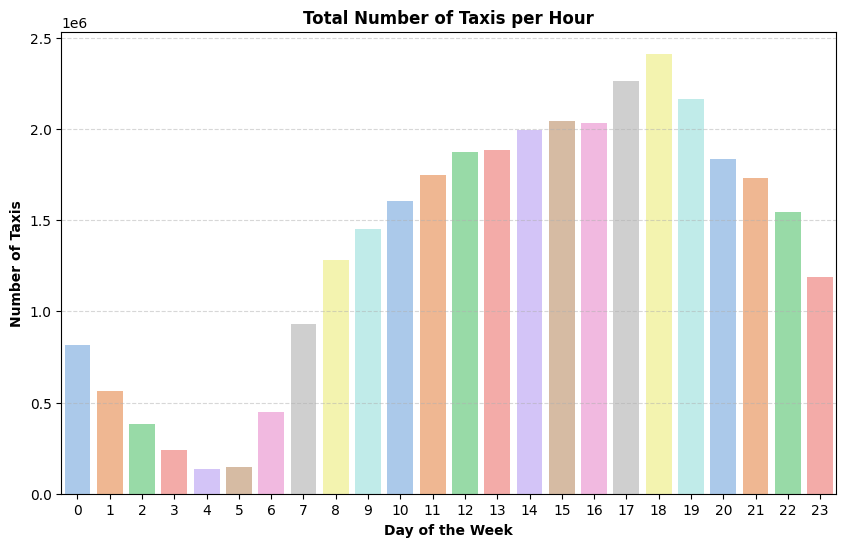

In [31]:
time_counts = df['time'].value_counts().sort_index()

sns.countplot(x='time', data=df, palette='pastel')
plt.xlabel('Day of the Week', fontweight='bold')
plt.ylabel('Number of Taxis', fontweight='bold')
plt.title('Total Number of Taxis per Hour', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

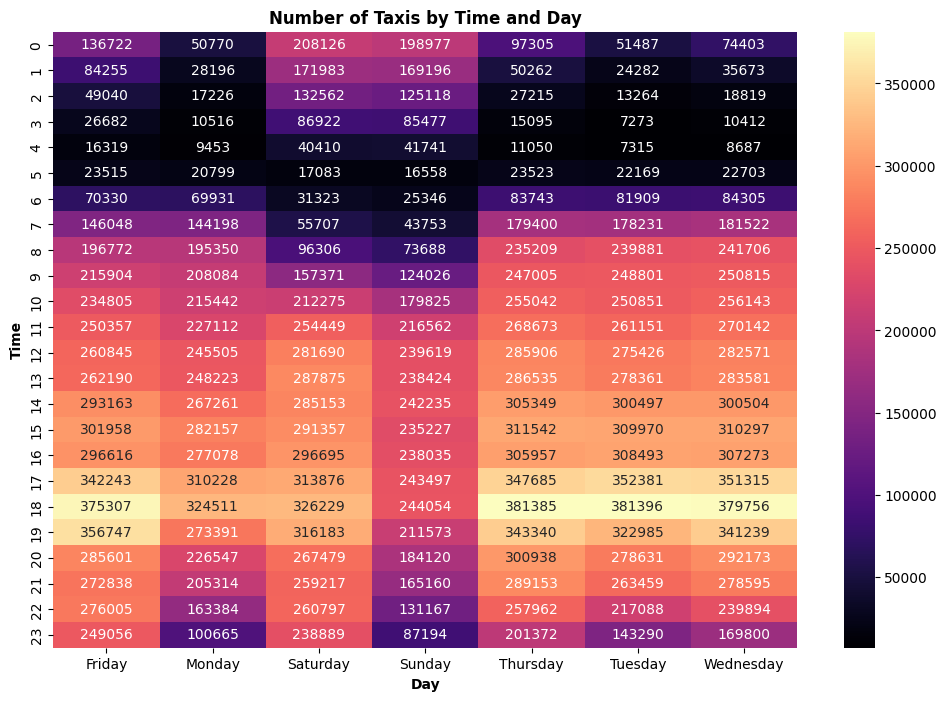

In [32]:
# Pivot the DataFrame to create a matrix of 'PULocationID' counts based on 'time' and 'day'
heatmap_data = df.pivot_table(index='time', columns='day_of_the_week', values='PULocationID', aggfunc='count')

# Create the heatmap using Seaborn with a different colormap
plt.figure(figsize=(12, 8))
sns.heatmap(data=heatmap_data, cmap='magma', annot=True, fmt='g', cbar=True)
plt.title('Number of Taxis by Time and Day', fontweight='bold')
plt.xlabel('Day', fontweight='bold')
plt.ylabel('Time', fontweight='bold')

plt.show()

**Observation:** It is clear from the plot and heatmap that evening time tends to be busiest for taxis, gradually increasing throughout the day before peaking between 6-7pm, after which it begins to decline again. This could be a useful predictor for busyness.

### Examing Taxis per Day of the Week

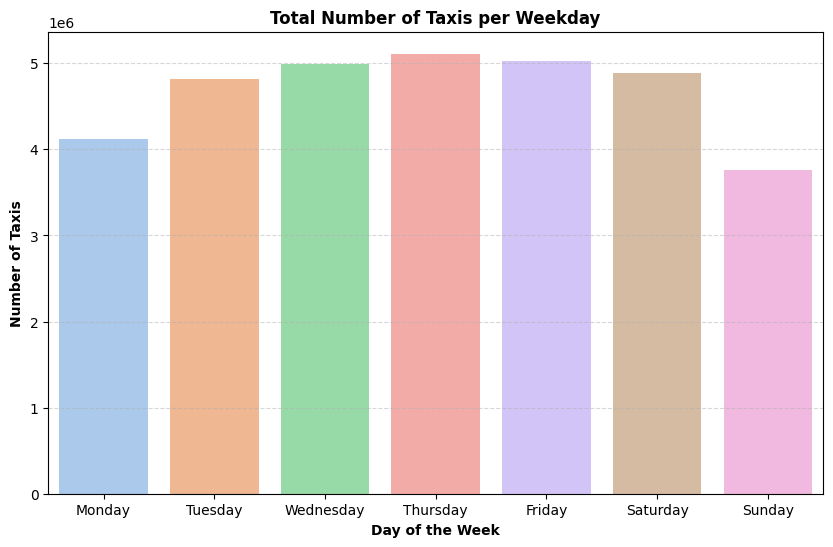

In [33]:
day_counts = df['day_of_the_week'].value_counts().sort_index()

# Get ordered list of weekday names
weekday_names = list(calendar.day_name)
ordered_weekdays = [weekday_names[i] for i in range(0, 7)]

# Create the bar plot using Seaborn
sns.countplot(x='day_of_the_week', data=df, order=ordered_weekdays, palette='pastel')

# Set labels and title
plt.xlabel('Day of the Week', fontweight='bold')
plt.ylabel('Number of Taxis', fontweight='bold')
plt.title('Total Number of Taxis per Weekday', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

**Observation:** Again, we can see from the plot that some days appear to be busier than others for taxis. In particular, Sunday and Monday seems to be the queitest days. Midweek appears to be slightly busier. Again, this could be a useful predictor for busyness.

### Examing Taxis per day of the month

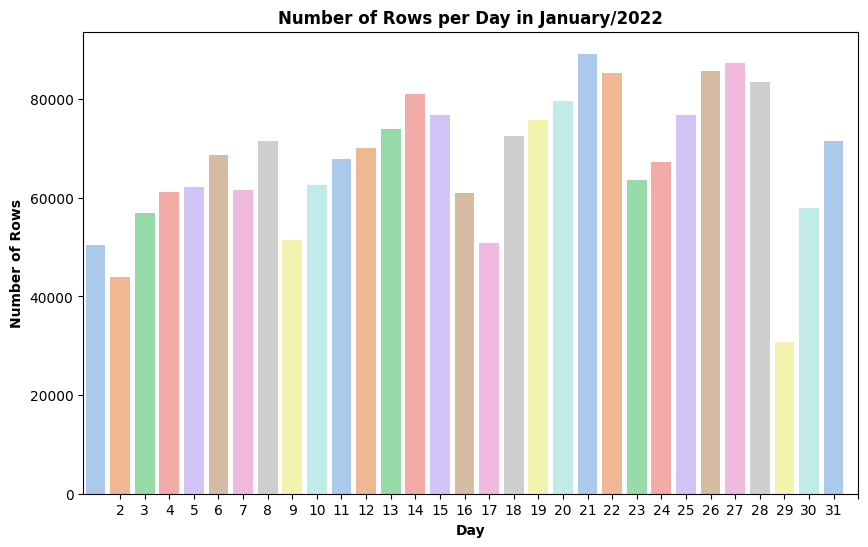

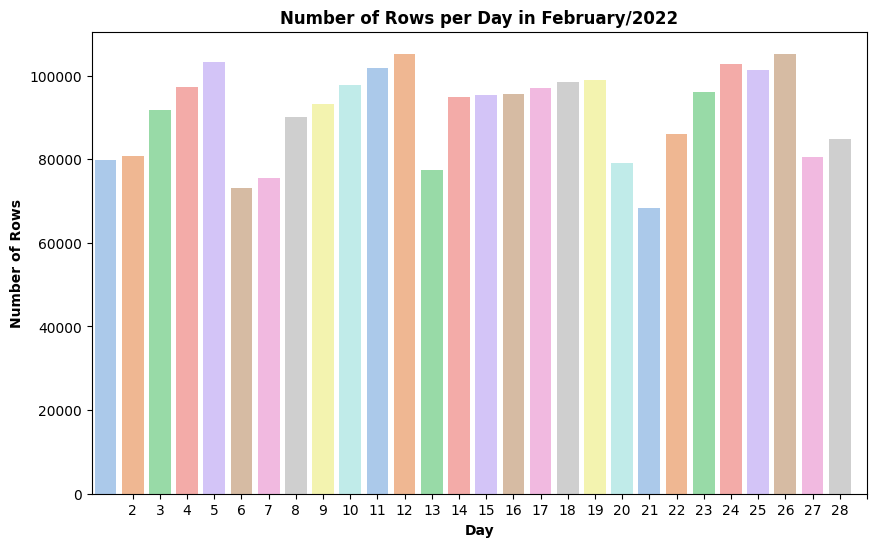

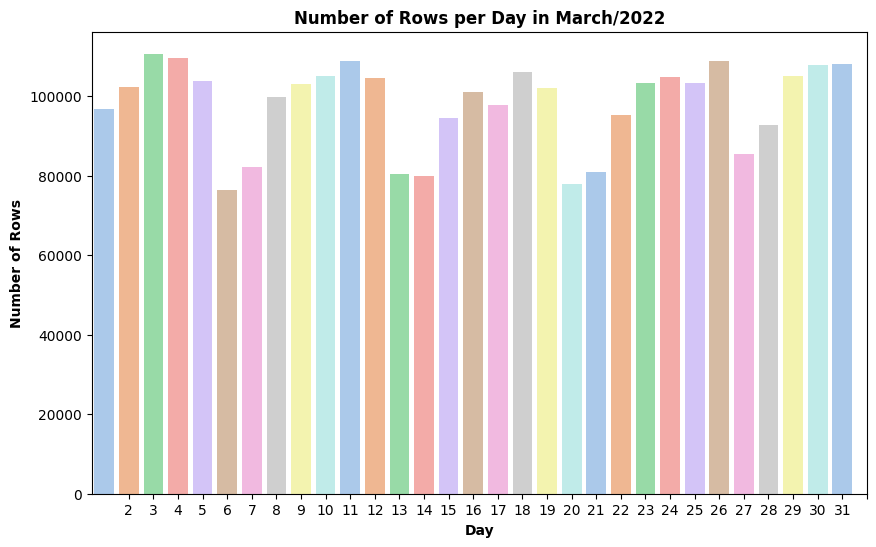

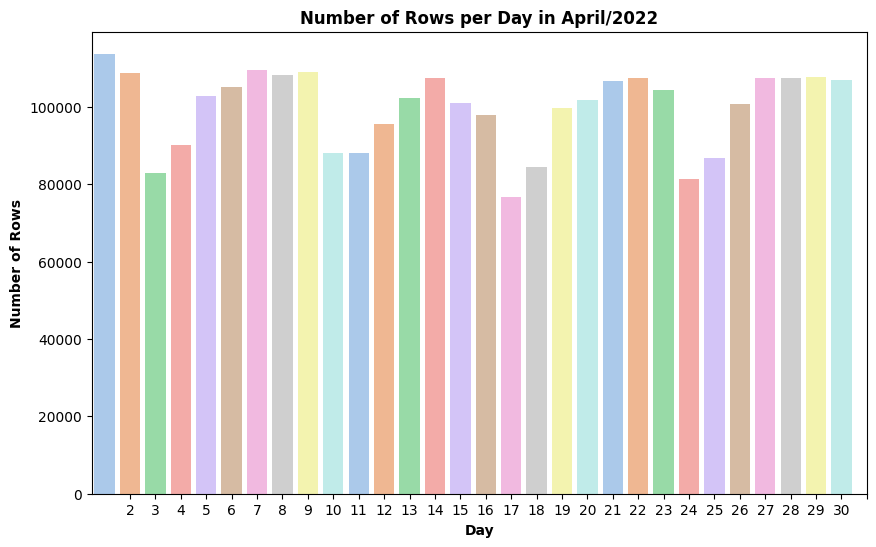

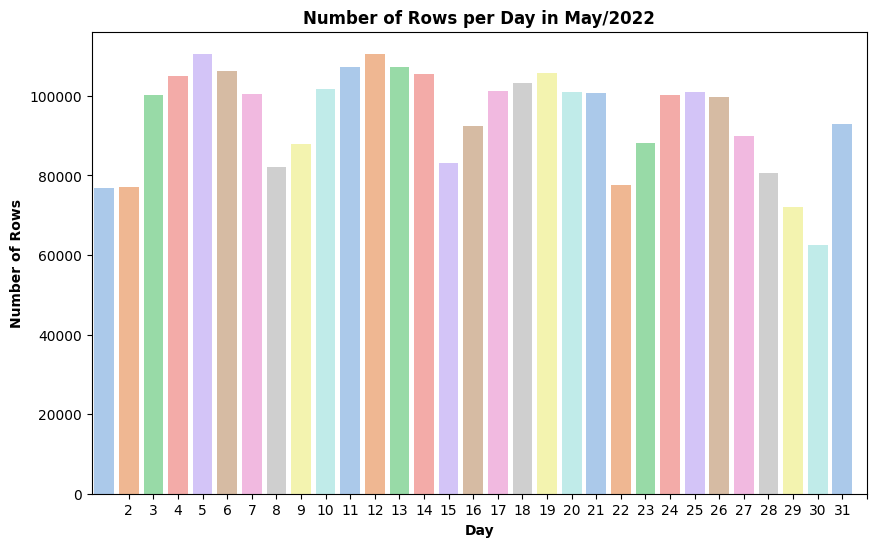

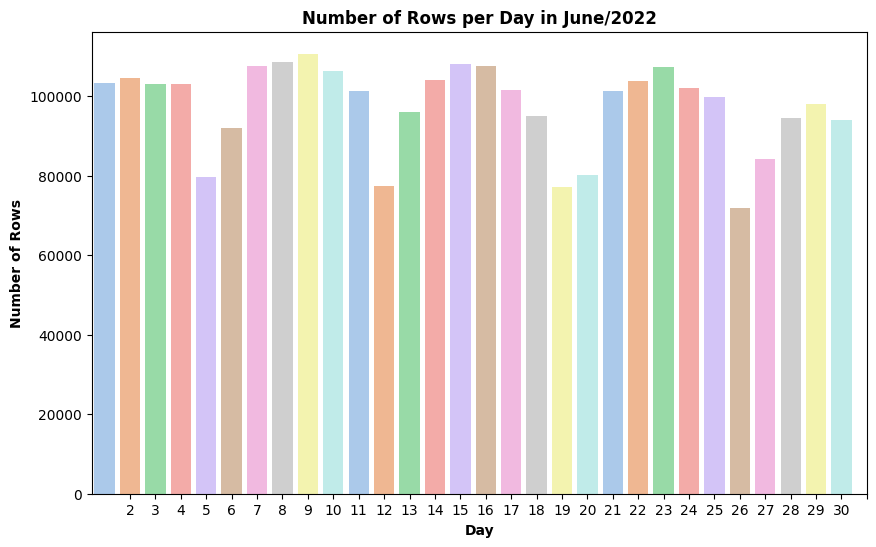

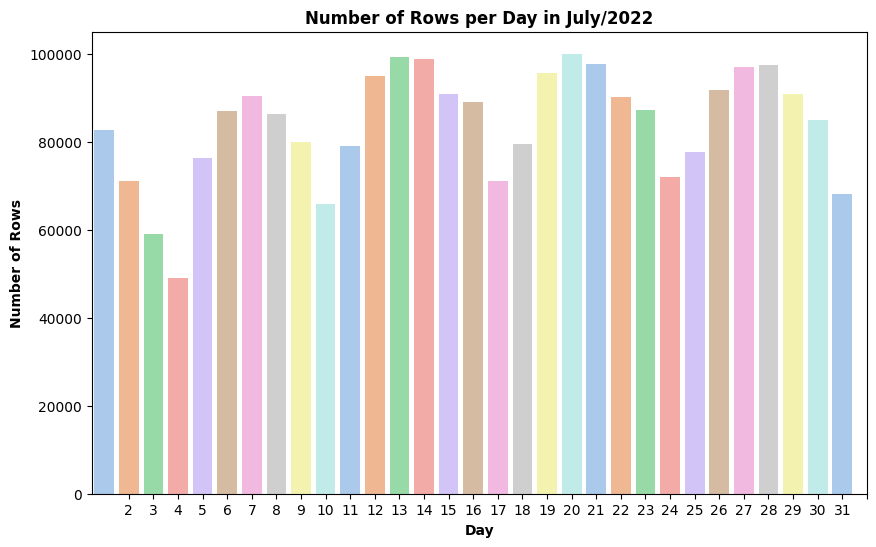

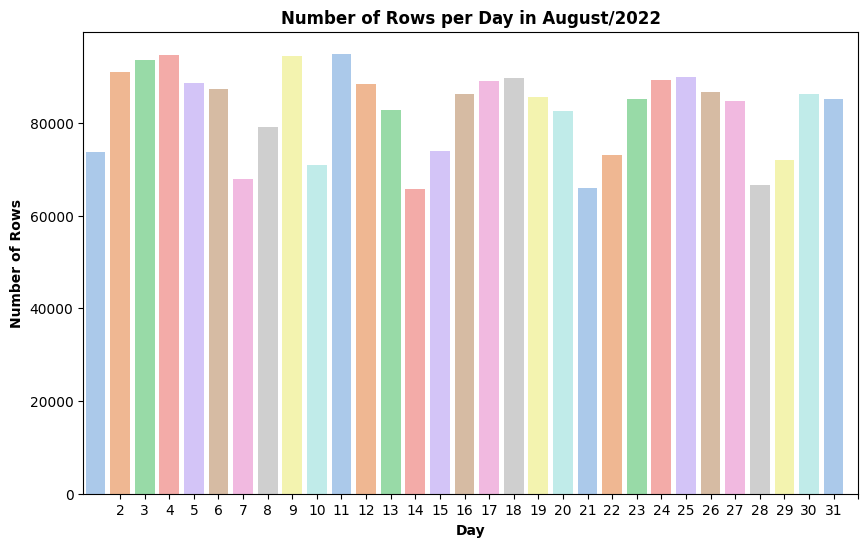

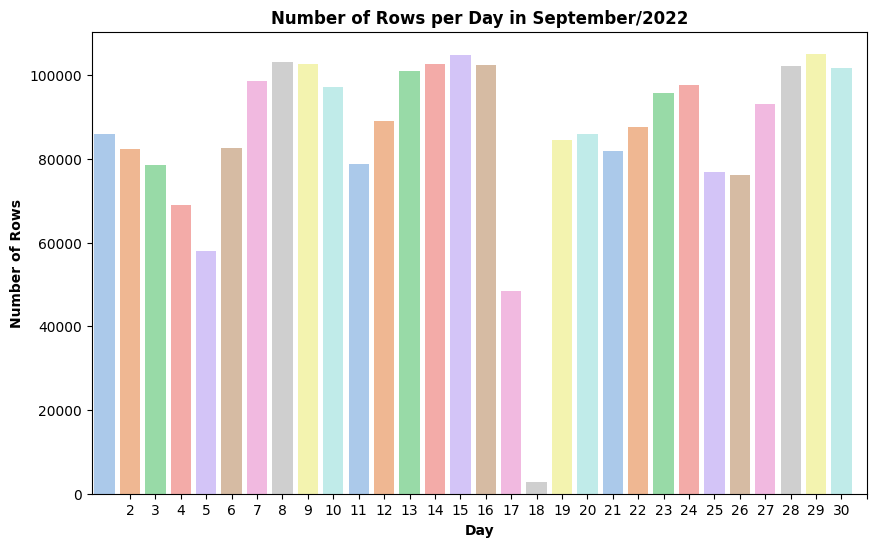

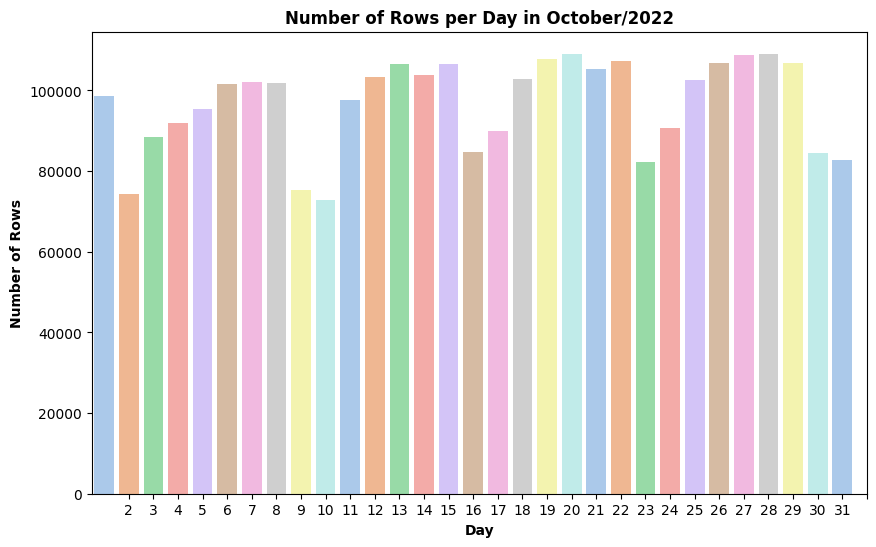

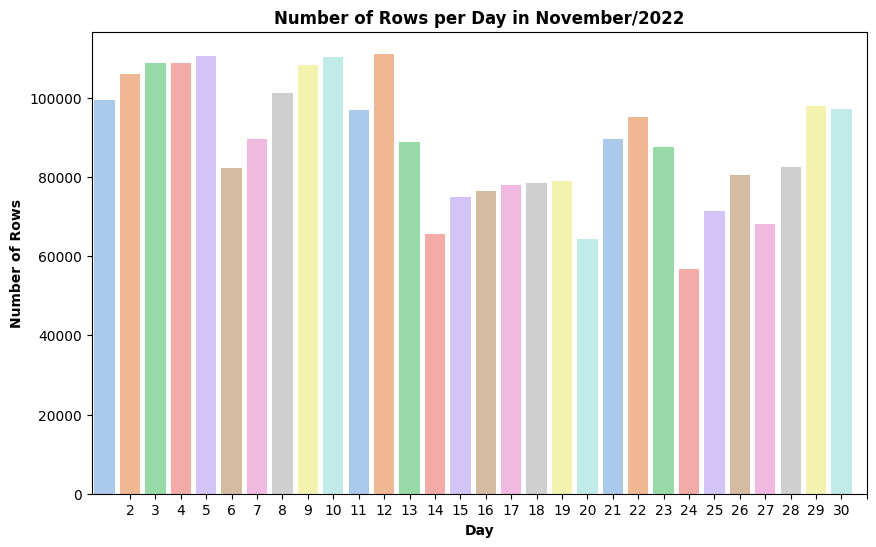

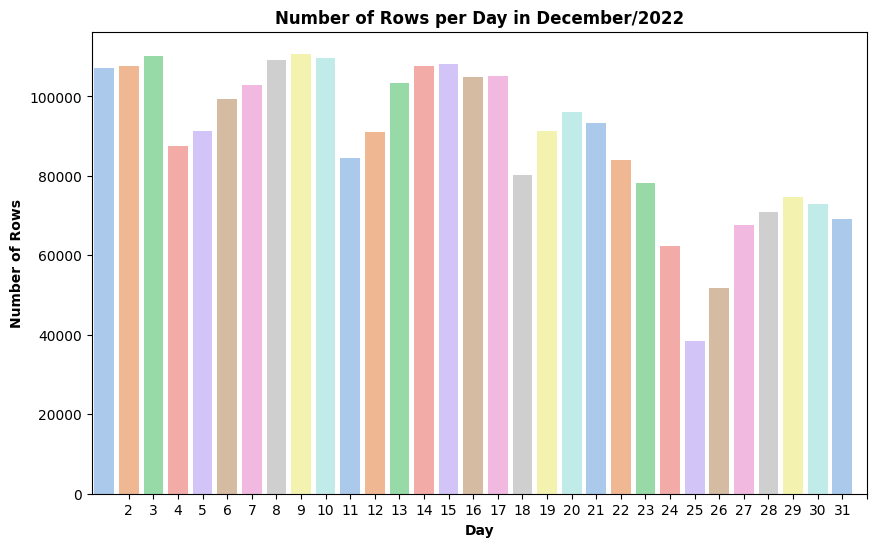

In [36]:
# Group the data by month
grouped_data = df.groupby(df['date'].dt.month)

# Iterate over each month and create separate plots
for month, group in grouped_data:
    # Get the count of rows for each day
    count_per_day = group.groupby(group['date'].dt.day)['date'].count()
    
    # Get the number of days in the current month
    num_days = calendar.monthrange(2022, month)[1]
    
    fig, ax = plt.subplots()
    
    sns.barplot(x=count_per_day.index, y=count_per_day.values, palette='pastel', ax=ax)
    
    # Set x-tick labels to include all days of the month
    ax.set_xticks(range(1, num_days + 1))
    
    month_name = calendar.month_name[month]
    ax.set_xlabel('Day', fontweight='bold')
    ax.set_ylabel('Number of Rows', fontweight='bold')
    ax.set_title(f'Number of Rows per Day in {month_name}/2022', fontweight='bold')
    
    plt.show()

**Observations:** We do see variance across the same days of the week across the same months. A clear example of this is Christmas week, it appears to be significantly quieter than the first 3 weeks in December. Thus, generalising to only day of the week may not capture this impact in our modelling. This will be kept in mind during model refinement.
<br><br>
Also for some reason, September 18th seemed to be extremely quiet compared to usual levels.

### Examing Taxis per Month

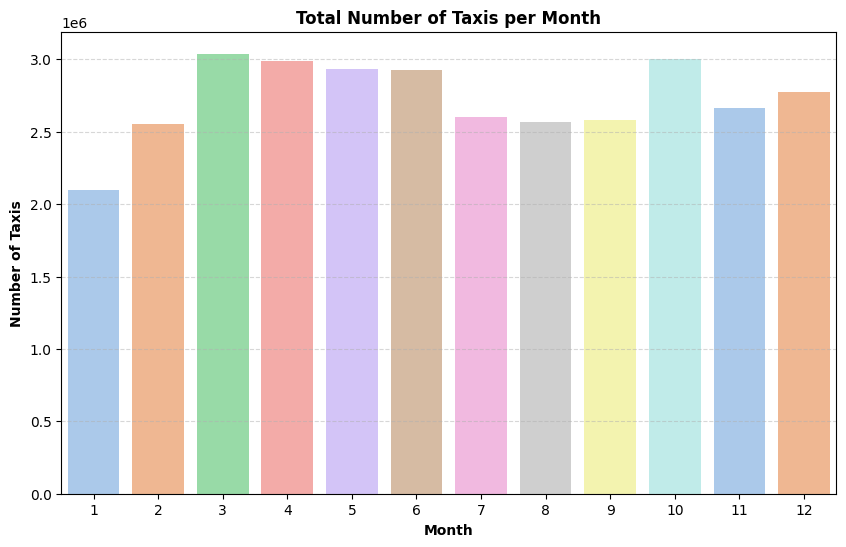

In [37]:
month_counts = df['month'].value_counts().sort_index()

# Create the bar plot using Seaborn
sns.countplot(x='month', data=df, order=month_counts.index, palette='pastel')

# Set labels and title
plt.xlabel('Month', fontweight='bold')
plt.ylabel('Number of Taxis', fontweight='bold')
plt.title('Total Number of Taxis per Month', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

**Observation:** Yet Again, we can see measurable differences in the number of taxis per month. We believe this to be another valuable predictor

**Overall Date Time Results:** Date time features all appear to be good predictors of busyness at a given time. Note that all the y-axis are scaled logaithmically. As such, small differences in the graph are even larger than they appear at first glance. These will definitely be tested further when it comes to building our model.

## Examing Categorical Columns
--- 

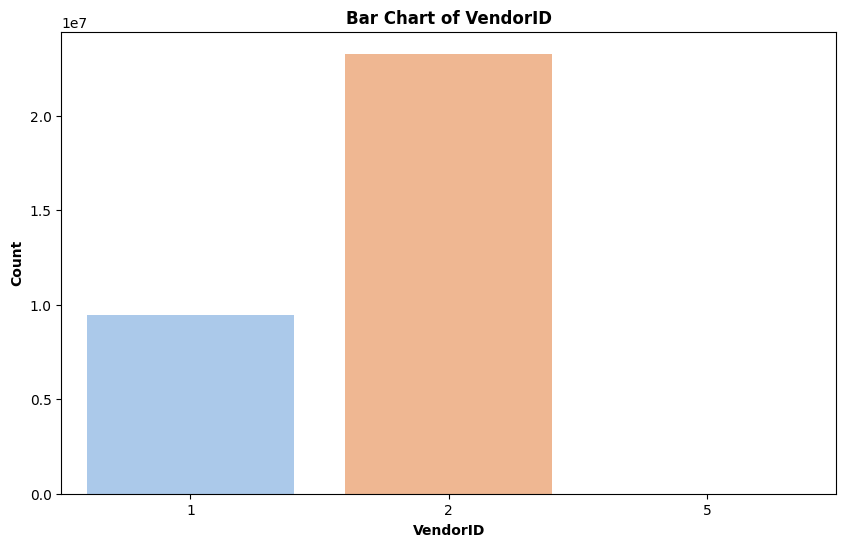

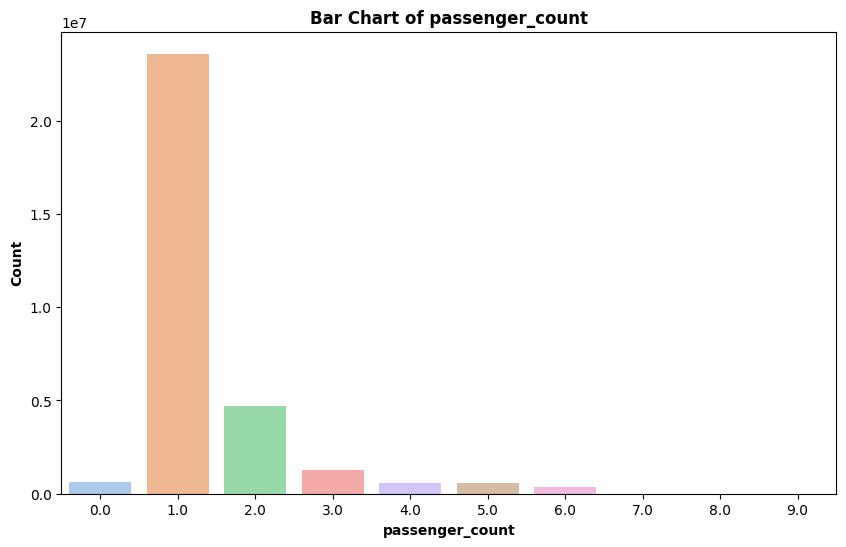

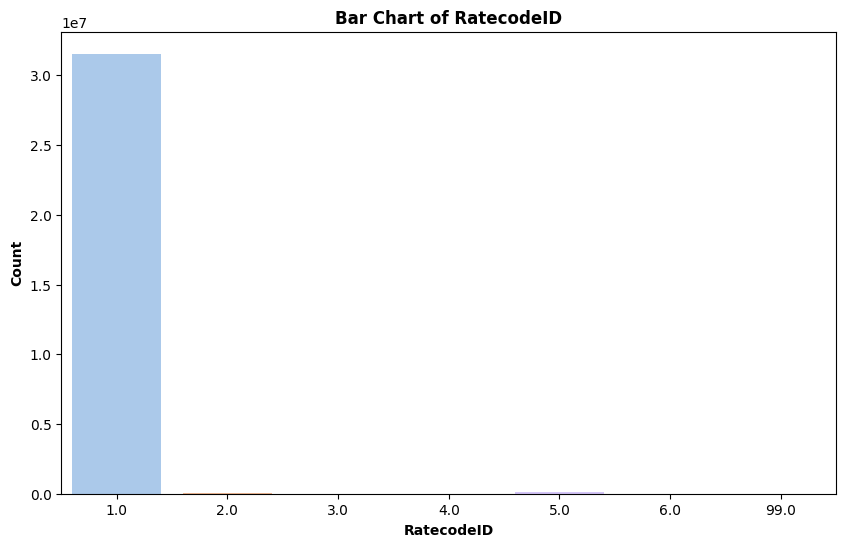

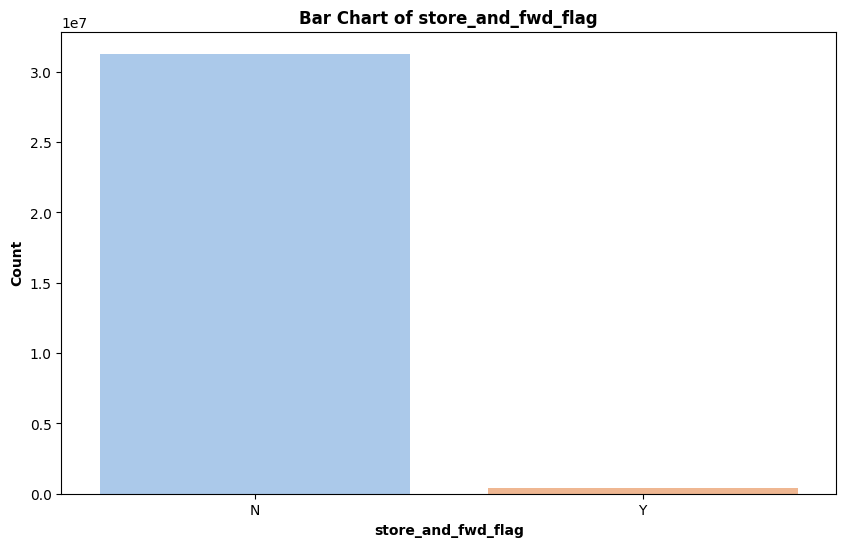

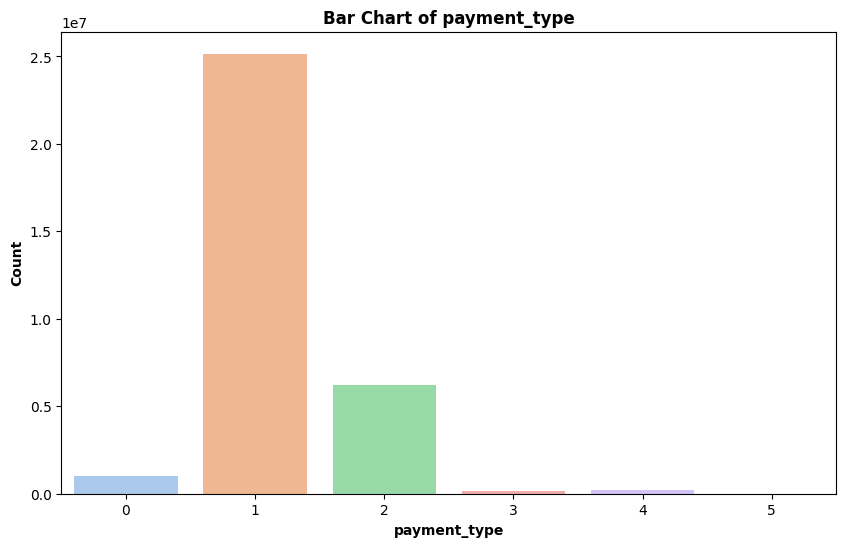

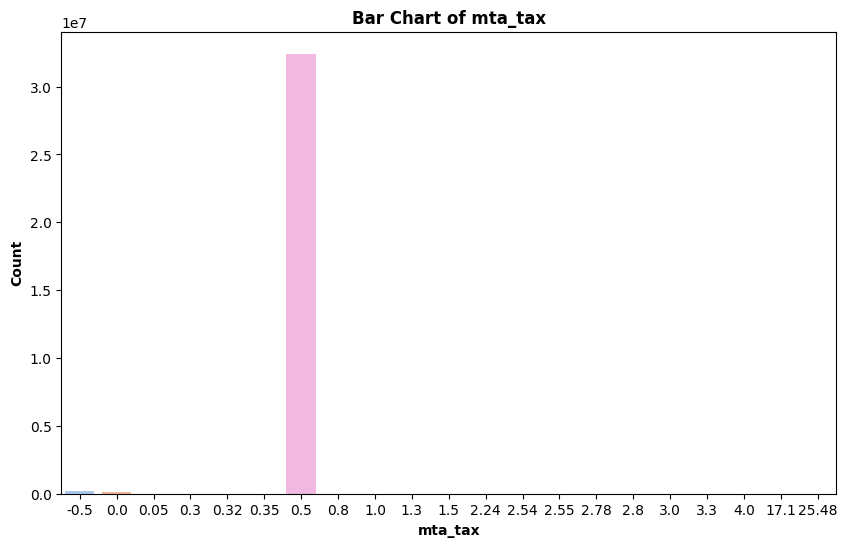

In [38]:
# Loop through each categorical column and plot a bar chart
for column in categorical_columns:
    # Count the occurrences of each unique value in the column
    value_counts = categorical_columns[column].value_counts()
    
    # Create a bar chart using Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=value_counts.index, y=value_counts.values, palette='pastel')
    plt.title(f'Bar Chart of {column}', fontweight='bold')
    plt.xlabel(column, fontweight='bold')
    plt.ylabel('Count', fontweight='bold')

    plt.show()

**Observation:** These are unlikely to provide much value towards our target goal of predicting busyness for an area. With the exception of passenger count which could be used to gain better insight as to the number of people dropped off in a given taxi zone. However, the plots do highlight some of the afforementioned data quality issues above, such as erroenous/outlying values. These will need to be cleaned.

## Examing Continuous Features
---

- We are going to first plot histograms for all continuous features. 
- Due to some extreme outliers, we set a lower and upper bound in order to avoid these outliers greatly disorting the plots. 
- The plots encompass the central 95% of the data.

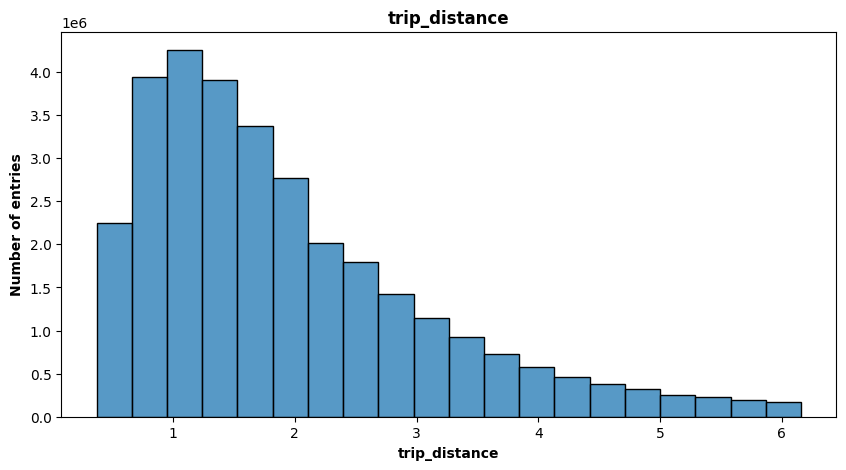

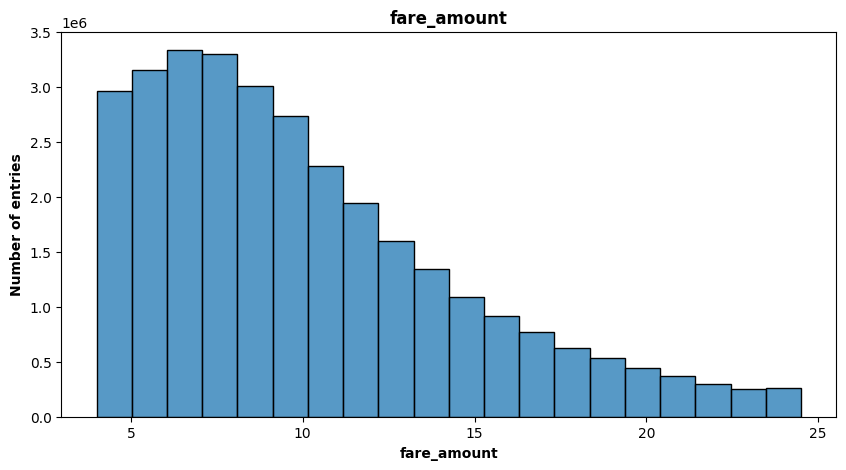

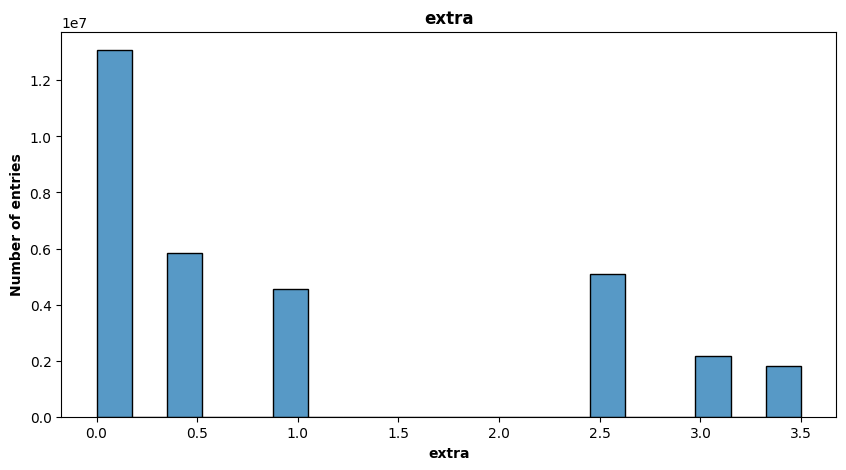

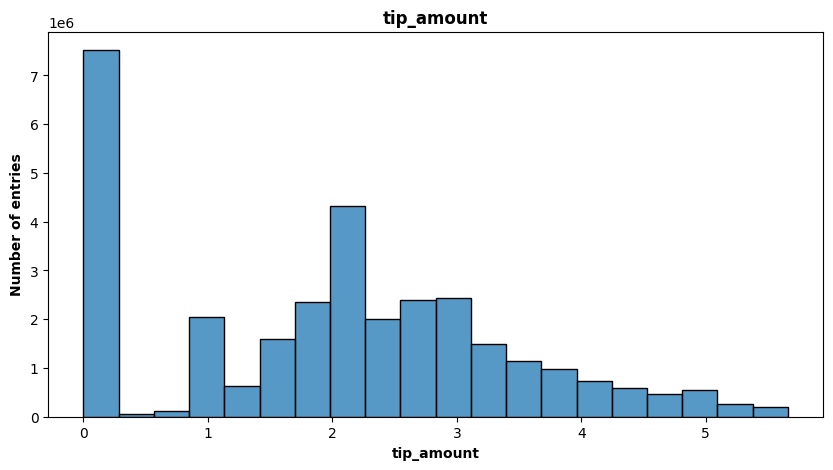

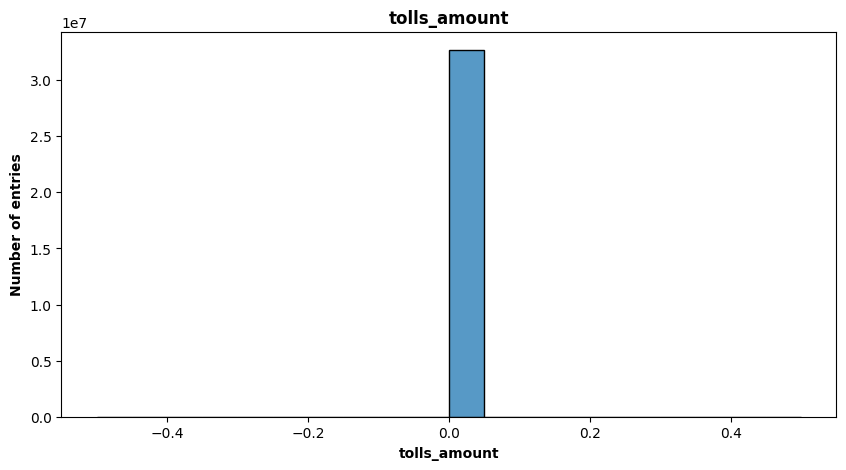

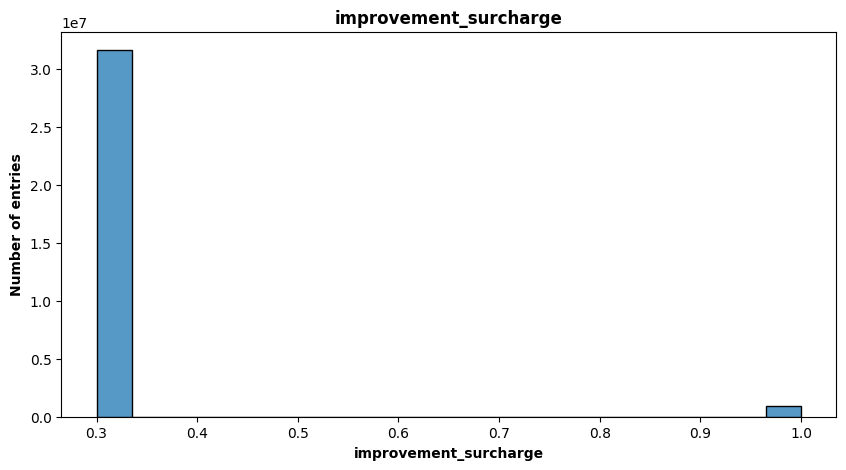

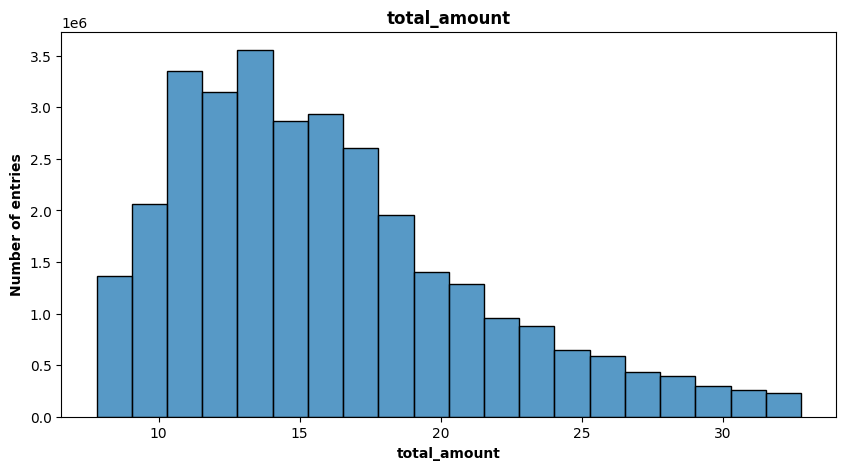

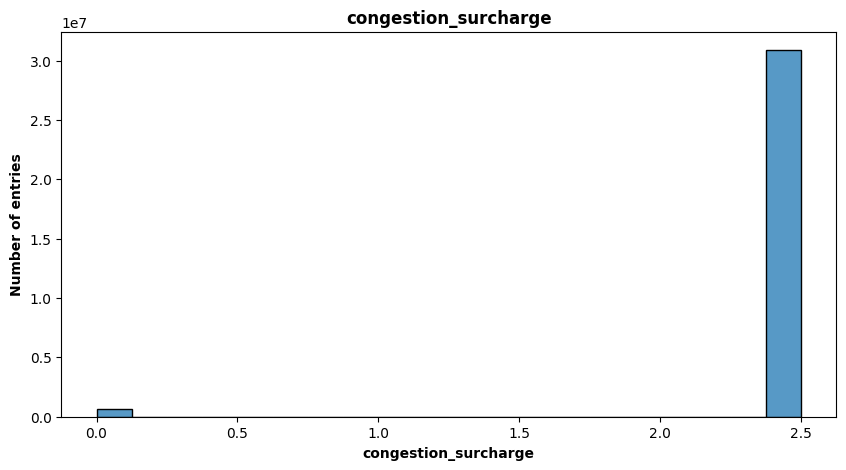

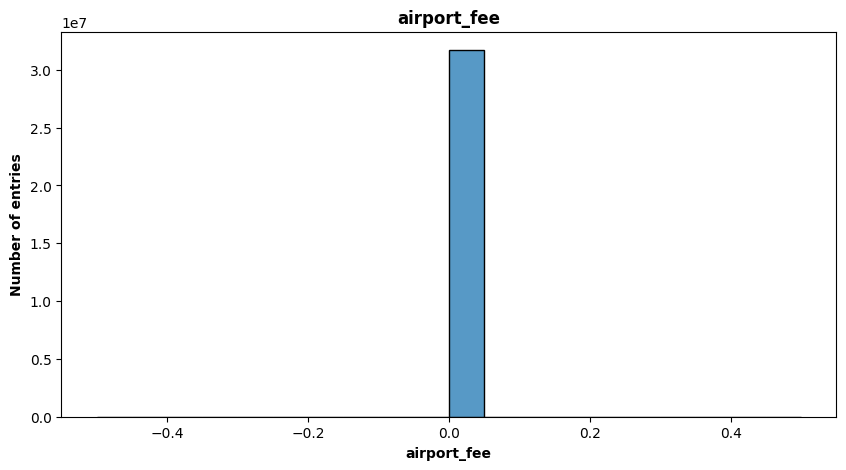

In [39]:
for col in continuous_columns:
    lower_bound = df[col].quantile(0.025)
    upper_bound = df[col].quantile(0.975)
    filtered_data = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    plt.figure(figsize=(10, 5))
    sns.histplot(data=filtered_data, x=col, bins=20)
    plt.title(col, fontweight='bold')
    plt.ylabel('Number of entries', fontweight='bold')
    plt.xlabel(col, fontweight='bold')
    plt.show()

Now, we are going to plot boxplots for each of the continuous features.

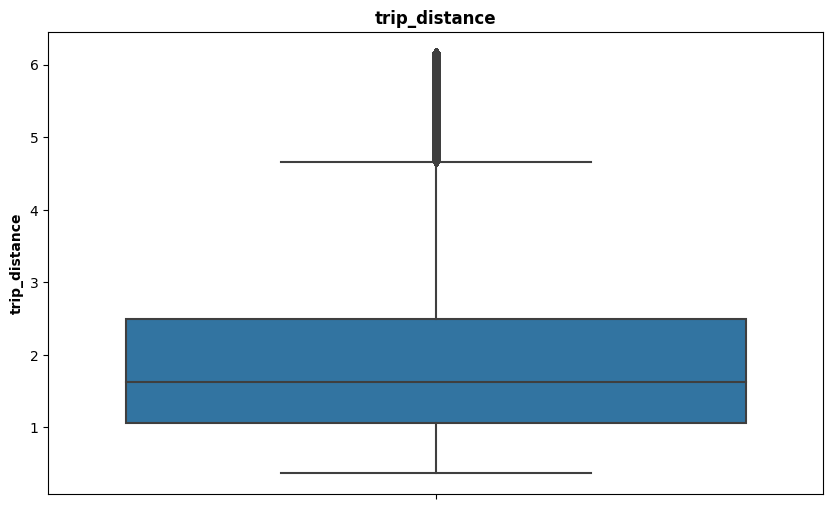

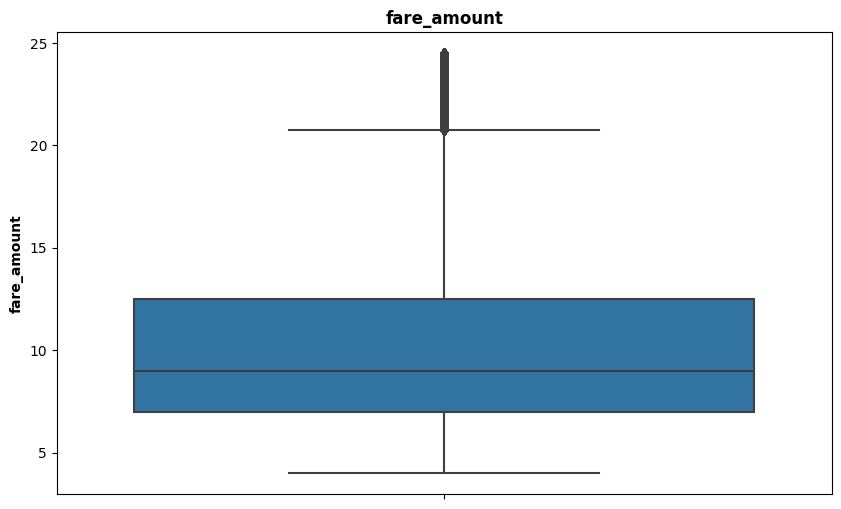

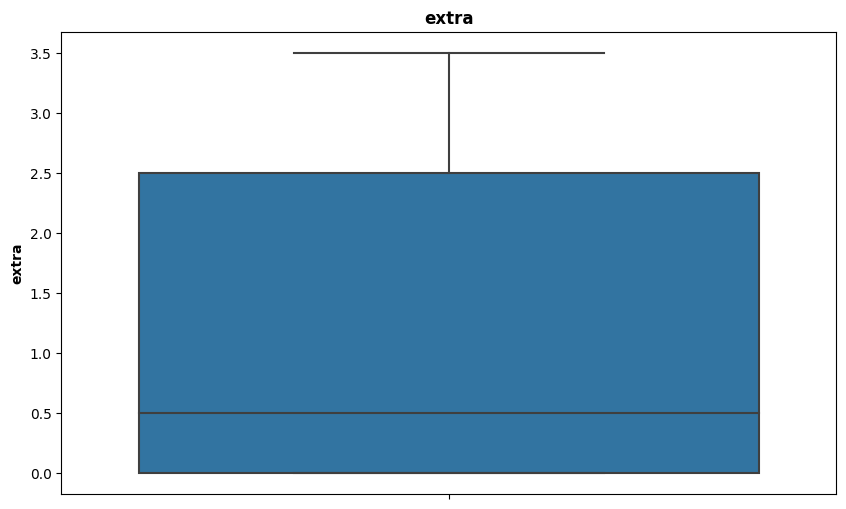

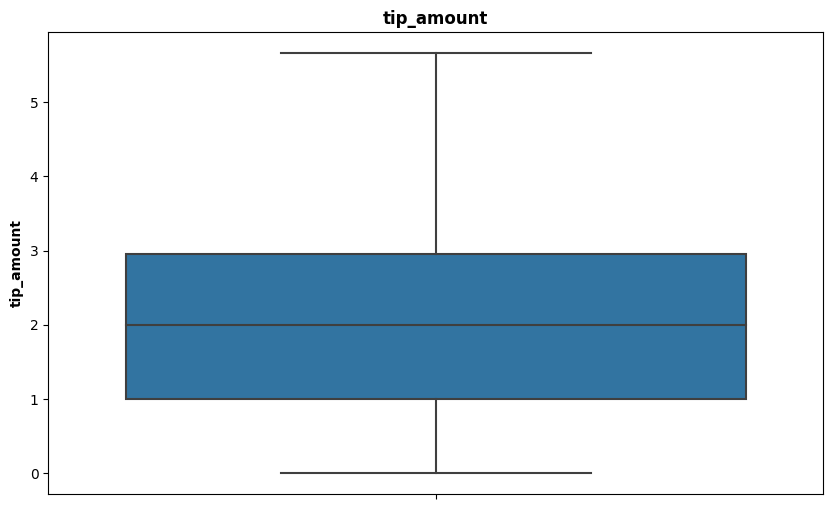

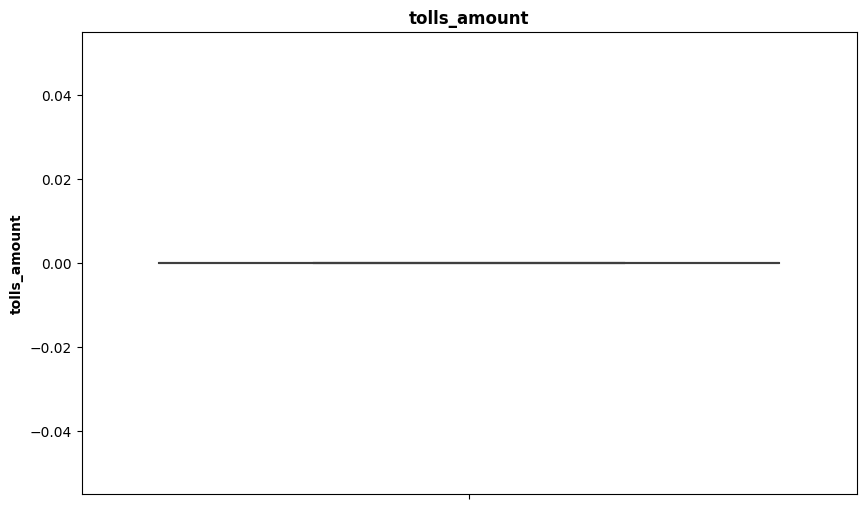

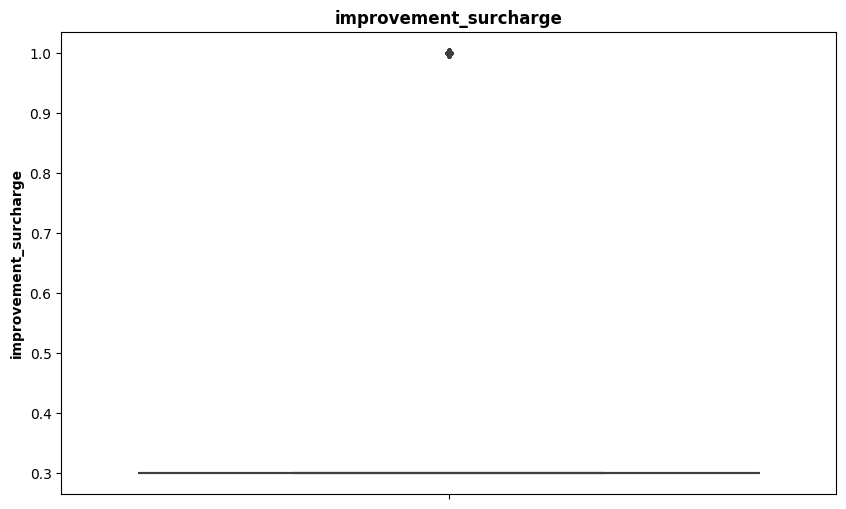

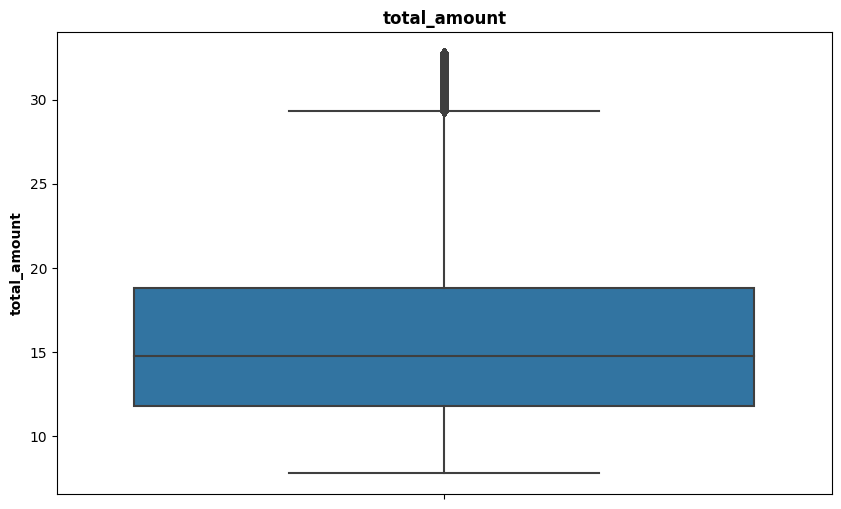

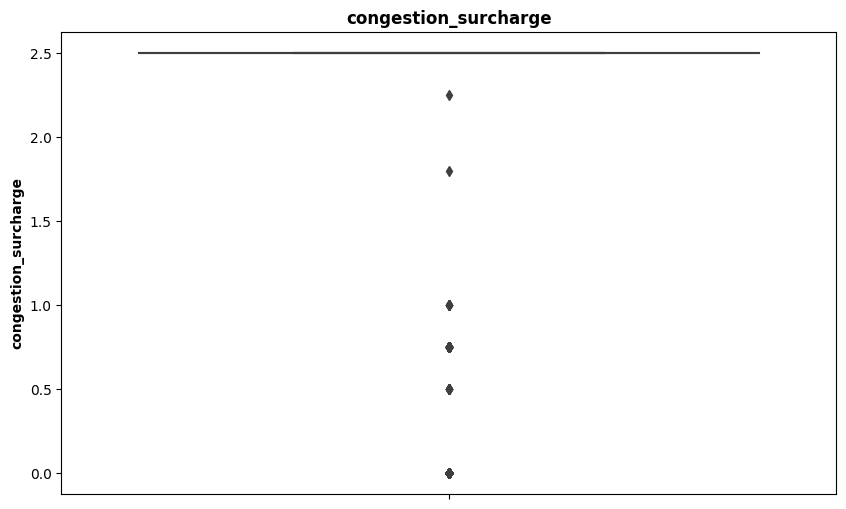

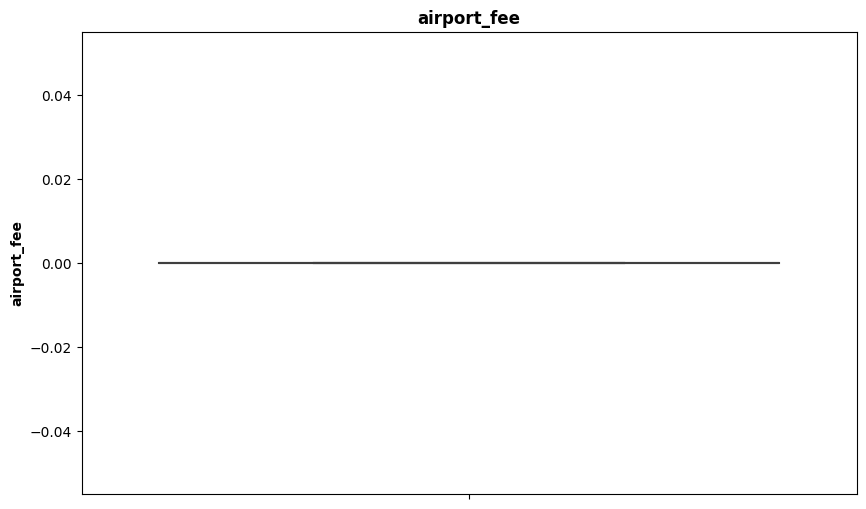

In [40]:
for col in continuous_columns:
    lower_bound = df[col].quantile(0.025)
    upper_bound = df[col].quantile(0.975)

    filtered_data = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    plt.figure()
    sns.boxplot(data=filtered_data, y=col)
    plt.title(col, fontweight='bold')
    plt.xlabel('')  # Remove x-axis label
    plt.ylabel(col, fontweight='bold')
    plt.show()

**Observations:**
- Some of the plots highlight outliers as well.
- While some features such as distance, tip amount, and fare amounts etc could provide interesting insight into typical taxi customer behaviour, and typical trends across taxi rides, these are not particularly useful for out target of predicting busyness for a particular area.
- These will likely be cleaned and dropped from the model, but it is worth noting for different projects these could be fascinating the analyse


## Examing Taxi Zones 
---

While Location IDs will likely be our predicted value, it is still useful to plot them. Due to high cardinality, the graphs will be difficult to interpret. However, it is to test that there is actually a significant difference between zones in Manhattan, and to ensure that caluclating a predictied number of dropoffs per zone will actually prove an apt determinant of busyness for a particlar area.

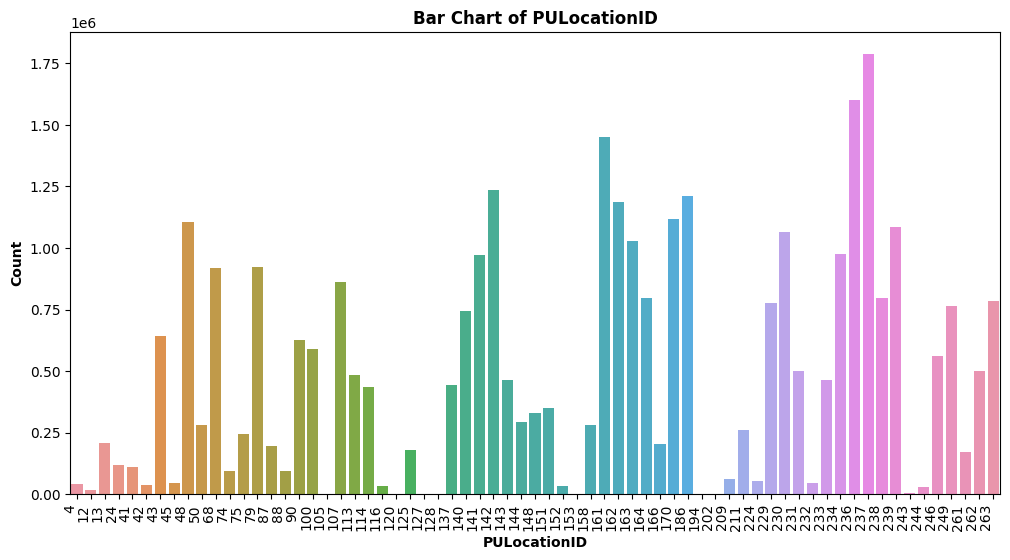

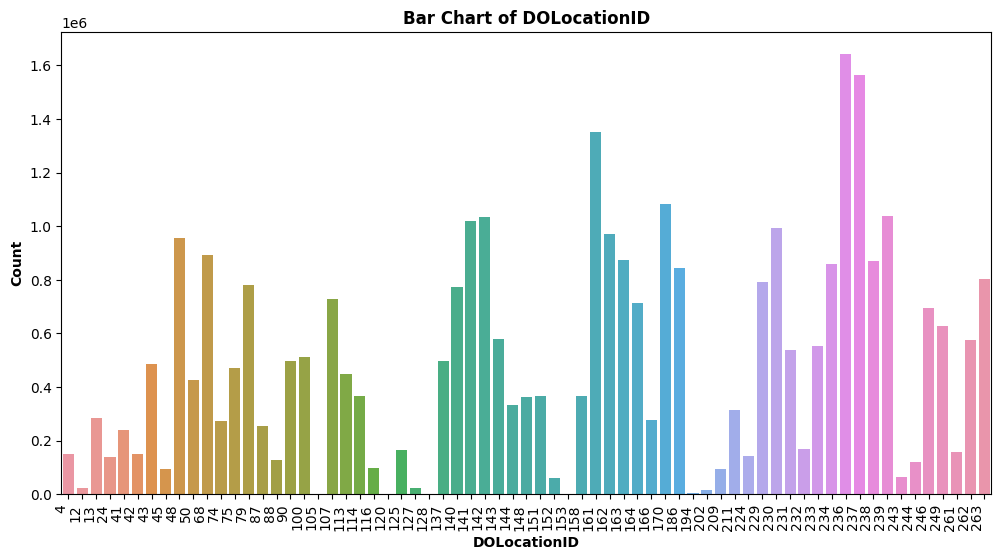

In [41]:
# Loop through each categorical column and plot a bar chart
for column in zones:
    # Count the occurrences of each unique value in the column
    value_counts = zones[column].value_counts()
    
    # Create a bar chart using Seaborn
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.title(f'Bar Chart of {column}', fontweight='bold')
    plt.xlabel(column, fontweight='bold')
    plt.ylabel('Count', fontweight='bold')
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')

    plt.show()

**Observations:** There is a stark difference in taxi pickups and dropoffs across Manhattan. This is promising. If we can predict a value for number of dropoffs, there should be a significant enough difference between zones to quanity certain zones as being busier than others.

### Overall Thoughts: 
- For our specific goals, date time features appear to be the most prominent features for identify busyness in general, espeically as these are easily gotten as inputs.
- For spicific events, we could also use PULocationID as a predictor, as if we know which zone the event is taking place we can use that as an input.
- Initial thoughts would be to have two models, one to predict general busyness, and another to specifically target pickups in an event zone, and see where is busyiest from taxis leaving picking up in that zone. Of course, this will require proper testing, but it seems promising.

## Data Quality Plan
---
### The initial data quality problems that have been identified are as follows:
From the initial data exploration, the main issues that have been identified:
- There are a number of missing values from the dataset. While many of the features are not related to our target outcome, passenger count may prove useful for our model. 
- There are some extreme outliers which do not seem plausible.
- There are negative values for features which again do not seem plausible.

From these issues, we have curated the following data quality plan to deal with them:

| Feature                 | Data Quality Issue         | Handling Strategy         |
|-------------------------|----------------------      |------------------------   |
|**VendorID**|None|Keep as is|
|**tpep_pickup_datetime**|Some values outside of 2022|Remove these rows, then extract into day, week, month features|
|**tpep_dropoff_datetime**|Some values outside of 2022|Remove these rows, then extract into day, week, month features|
|**Passneger_count**|Missing values (approx 3%)|Impute to modal value|
|**PULocationID**|None|Keep as is|
|**DOLocationID**|None|Keep as is|
|**RateCodeID**|Missing values (approx 3%)|Keep as is, drop feature as not related to target outcome|
|**Store_and_fwd_flag**|Missing values (approx 3%)|Keep as is, drop feature as not related to target outcome|
|**Payment_Type**|None|Keep as is, drop feature as not related to target outcome|
|**Fare_amount**|Negative values, Extreme outliers|Remove affected rows, drop features as not related to target outcome|
|**Extra**|Negative values|Remove affected rows, drop features as not related to target outcome|
|**MTA_tax**|Negative values|Remove affected rows, drop features as not related to target outcome|
|**Improvement_surcharge**|Negative values|Remove affected rows, drop features as not related to target outcome|
|**Tip_amount**|Negative values, Extreme outliers|Remove affected rows, drop features as not related to target outcome|
|**Tolls_amount**|Negative values, Extreme outliers|Remove affected rows, drop features as not related to target outcome|
|**Total_amount**|Negative values, Extreme outliers|Remove affected rows, drop features as not related to target outcome|
|**congestion_surcharge**|Missing values (approx 3%)|Keep as is, drop feature as not related to target outcome|
|**airport_fee**|Missing values (approx 3%)|Keep as is, drop feature as not related to target outcome|


**Justifications:**
- For passenger count, we are imputing to the modal value. This is a driver entered value so it seems plausible it could be due to human error. Most trips are predominantly only one passenger, so it seems reasonable to use this value for the missing values.
- For features containing negative values and extreme outliers, it is difficult to tell what has caused these erroneous values without more insight into how the data collection process works with the meter. As these are only a small proportion of the entire dataset, removing these rows should not have a large impact on our prediciton, and seems appropriate.
- Many of the continuous features will be dropped before modelling. While these features can prvide rich insights into passenger and trip tendencies, they are not related to busyness and as such provide little use for our specific goal.

We will also be removing any rows which failed the logical tests above.

## Data Cleaning:
---

#### First, Imputing missing passenger count values to modal value (ie. 1)

In [42]:
df['passenger_count'] = df['passenger_count'].fillna(1)

#### Next, Removing dates outside of 2022

In [43]:
rows_to_remove = dates_before_or_after_2022.index
df = df.drop(rows_to_remove)

#### Removing passenger counts > 6

In [44]:
rows_to_remove = passenger_count_test.index
df = df.drop(rows_to_remove)

#### Removing negative distances trips and extreme high distance trips

In [45]:
df = df[df['trip_distance'] < 100]
df = df[df['trip_distance'] > 0]

#### Removing all rows with negative values

In [46]:
df = df[df['fare_amount'] >= 0]
df = df[df['extra'] >= 0]
df = df[df['mta_tax'] >= 0]
df = df[df['tip_amount'] >= 0]
df = df[df['tolls_amount'] >= 0]
df = df[df['improvement_surcharge'] >= 0]
df = df[df['total_amount'] >= 0]
df = df[df['congestion_surcharge'] >= 0]
df = df[df['airport_fee'] >= 0]

#### Lastly, removing extreme fares and total amounts. We saw above some fares seemed highly implausible

In [47]:
df = df[df['fare_amount'] <= 500]
df = df[df['total_amount'] <= 500]

## Double Checking and Saving Cleaned Taxi Data
--- 

Finally, we are just ensuring everything looks correct after tidying, and that all negative/missing/extreme values have indeed been removed. Then, we save the cleaned data to a .csv file for later use in our predictive modelling.

In [48]:
df.shape

(31323476, 21)

In [49]:
df.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,date,month,time,day_of_the_week
0,1,2.0,3.80,1.0,N,142,236,1,14.5,3.0,...,3.65,0.0,0.3,21.95,2.5,0.0,2022-01-01,1,0,Saturday
1,1,1.0,2.10,1.0,N,236,42,1,8.0,0.5,...,4.00,0.0,0.3,13.30,0.0,0.0,2022-01-01,1,0,Saturday
2,2,1.0,0.97,1.0,N,166,166,1,7.5,0.5,...,1.76,0.0,0.3,10.56,0.0,0.0,2022-01-01,1,0,Saturday
3,2,1.0,1.09,1.0,N,114,68,2,8.0,0.5,...,0.00,0.0,0.3,11.80,2.5,0.0,2022-01-01,1,0,Saturday
4,2,1.0,4.30,1.0,N,68,163,1,23.5,0.5,...,3.00,0.0,0.3,30.30,2.5,0.0,2022-01-01,1,0,Saturday


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31323476 entries, 0 to 3273085
Data columns (total 21 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   passenger_count        float64       
 2   trip_distance          float64       
 3   RatecodeID             float64       
 4   store_and_fwd_flag     object        
 5   PULocationID           int64         
 6   DOLocationID           int64         
 7   payment_type           int64         
 8   fare_amount            float64       
 9   extra                  float64       
 10  mta_tax                float64       
 11  tip_amount             float64       
 12  tolls_amount           float64       
 13  improvement_surcharge  float64       
 14  total_amount           float64       
 15  congestion_surcharge   float64       
 16  airport_fee            float64       
 17  date                   datetime64[ns]
 18  month                

In [51]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorID,31323476.0,1.708657,0.454381,1.00,1.00,2.00,2.00,2.00
passenger_count,31323476.0,1.394971,0.965235,0.00,1.00,1.00,1.00,6.00
trip_distance,31323476.0,2.031142,1.491382,0.01,1.03,1.62,2.56,99.30
RatecodeID,31323476.0,1.033020,1.671822,1.00,1.00,1.00,1.00,99.00
PULocationID,31323476.0,167.637830,65.886729,4.00,125.00,163.00,234.00,263.00
DOLocationID,31323476.0,166.331311,68.219543,4.00,114.00,163.00,234.00,263.00
payment_type,31323476.0,1.207951,0.427962,1.00,1.00,1.00,1.00,5.00
fare_amount,31323476.0,10.397345,5.446897,0.00,6.50,9.00,12.50,495.50
extra,31323476.0,1.057947,1.205596,0.00,0.00,0.50,2.50,15.60
mta_tax,31323476.0,0.499470,0.019640,0.00,0.50,0.50,0.50,17.10


In [52]:
df.isnull().sum()

VendorID                 0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
date                     0
month                    0
time                     0
day_of_the_week          0
dtype: int64

In [53]:
negative_counts = {}

# Iterate over each column in the DataFrame
for column in df.columns:
    # Check if the values in the column are numeric
    if pd.api.types.is_numeric_dtype(df[column]):
        # Count the number of negative values in the column
        negative_count = df[column].lt(0).sum()
        # Store the column name and corresponding count in the dictionary
        negative_counts[column] = negative_count

# Print the column names and the corresponding counts of negative values
for column, count in negative_counts.items():
    print(f"Column '{column}' has {count} negative value(s).")

Column 'VendorID' has 0 negative value(s).
Column 'passenger_count' has 0 negative value(s).
Column 'trip_distance' has 0 negative value(s).
Column 'RatecodeID' has 0 negative value(s).
Column 'PULocationID' has 0 negative value(s).
Column 'DOLocationID' has 0 negative value(s).
Column 'payment_type' has 0 negative value(s).
Column 'fare_amount' has 0 negative value(s).
Column 'extra' has 0 negative value(s).
Column 'mta_tax' has 0 negative value(s).
Column 'tip_amount' has 0 negative value(s).
Column 'tolls_amount' has 0 negative value(s).
Column 'improvement_surcharge' has 0 negative value(s).
Column 'total_amount' has 0 negative value(s).
Column 'congestion_surcharge' has 0 negative value(s).
Column 'airport_fee' has 0 negative value(s).
Column 'month' has 0 negative value(s).
Column 'time' has 0 negative value(s).


Everything appears to have been cleaned, and we are now finished with the preliminary data exploration & cleaning.

In [ ]:
df.to_csv('2022_taxi_data_cleaned.csv', index=False)

## Experimenting with Basic Zone Denisty Visualisations
---

Below code is from: https://github.com/greysonchung/New-York-Taxi-Data-Analysis/blob/main/code/visualisation.ipynb

In [54]:
# Read in the taxi zone shapefile
sf = gpd.read_file('NYC_Taxi_Zones/zones.shp')
zone = pd.read_csv("NYC_Taxi_Zones/taxi_zone_lookup.csv")

# Set CRS for the GeoDataFrame
#sf = sf.set_crs('epsg:2263')

# Convert the geometry to the desired CRS
sf['geometry'] = sf['geometry'].to_crs('epsg:4326')

In [55]:
sf

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."
...,...,...,...,...,...,...,...
258,Brooklyn,256.0,256.0,0.000169,0.067915,Williamsburg (South Side),"POLYGON ((-73.95834 40.71331, -73.95681 40.712..."
259,Bronx,259.0,259.0,0.000395,0.126750,Woodlawn/Wakefield,"POLYGON ((-73.85107 40.91037, -73.85207 40.909..."
260,Queens,260.0,260.0,0.000422,0.133514,Woodside,"POLYGON ((-73.90175 40.76078, -73.90147 40.759..."
261,Manhattan,261.0,261.0,0.000034,0.027120,World Trade Center,"POLYGON ((-74.01333 40.70503, -74.01327 40.704..."


In [56]:
zone

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NV,NaN


In [57]:
# Compute pickup and dropoff amount of each zone
pu_zone = df.groupby(['PULocationID'], as_index=False).size()
do_zone = df.groupby(['DOLocationID'], as_index=False).size()
pu_zone = gpd.GeoDataFrame(pd.merge(pu_zone, sf, left_on='PULocationID', right_on='location_i')).drop('location_i', axis=1)
do_zone = gpd.GeoDataFrame(pd.merge(do_zone, sf, left_on='DOLocationID', right_on='location_i')).drop('location_i', axis=1)
pu_zone = pu_zone.to_crs(epsg=3857)
do_zone = do_zone.to_crs(epsg=3857)

In [58]:
# Compute pickup and dropoff amount of each zone
pu_zone_counts = df['PULocationID'].value_counts().reset_index()
do_zone_counts = df['DOLocationID'].value_counts().reset_index()

# Merge with the shapefile DataFrame
pu_zone = pd.merge(pu_zone_counts, sf, left_on='index', right_on='location_i')
do_zone = pd.merge(do_zone_counts, sf, left_on='index', right_on='location_i')

# Create GeoDataFrames
pu_zone = gpd.GeoDataFrame(pu_zone).rename(columns={'index': 'PULocationID', 'PULocationID': 'size'})
do_zone = gpd.GeoDataFrame(do_zone).rename(columns={'index': 'DOLocationID', 'DOLocationID': 'size'})

### Zone Density Heatmap using Logarithmic Scale

/Users/cianreilly/miniconda3/envs/comp47350py38/lib/python3.8/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 30 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)
/Users/cianreilly/miniconda3/envs/comp47350py38/lib/python3.8/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 30 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


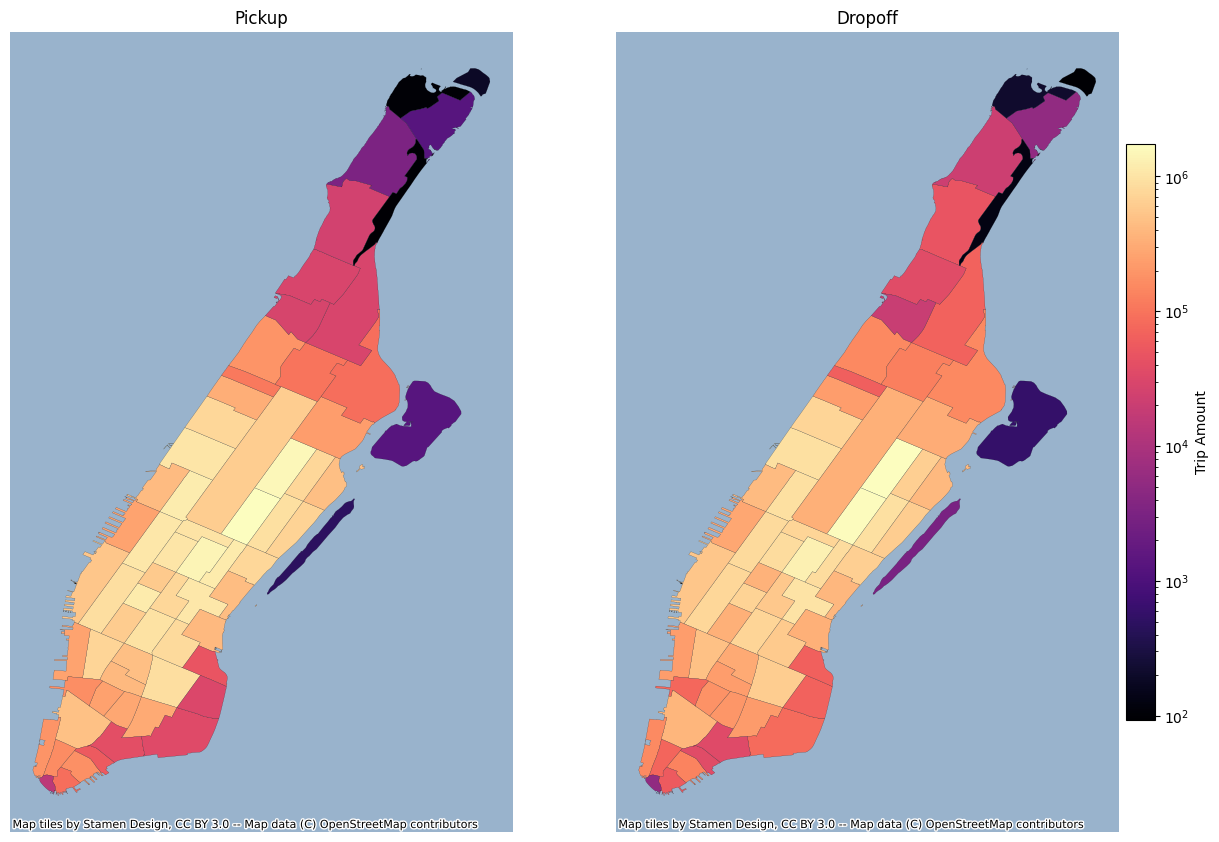

In [59]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 10))
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.09, right=0.8, wspace=0.02, hspace=0.02)

# Shared plot parameters
plot_params = {
    'linewidth': 0.1,
    'edgecolor': 'k',
    'cmap': 'magma',
    'legend': False,
}

# Data, titles, and axes for the plots
data = [(pu_zone, axs[0], 'Pickup'), (do_zone, axs[1], 'Dropoff')]

for zone_data, ax, title in data:
    vmin, vmax = zone_data['size'].min(), zone_data['size'].max()
    ax = zone_data.plot(column='size', norm=colors.LogNorm(vmin=vmin, vmax=vmax), ax=ax, **plot_params)
    ctx.add_basemap(ax)
    ax.set_title(title)
    ax.set_axis_off()

# draw the color bar
patch_col = axs[0].collections[0]
cb = fig.colorbar(patch_col, ax=axs, shrink=0.72, orientation="vertical", pad=0.005)
cb.ax.set_ylabel('Trip Amount')
plt.show()


### Zone Density Heatmap using Linear Scale

/Users/cianreilly/miniconda3/envs/comp47350py38/lib/python3.8/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 30 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)
/Users/cianreilly/miniconda3/envs/comp47350py38/lib/python3.8/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 30 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


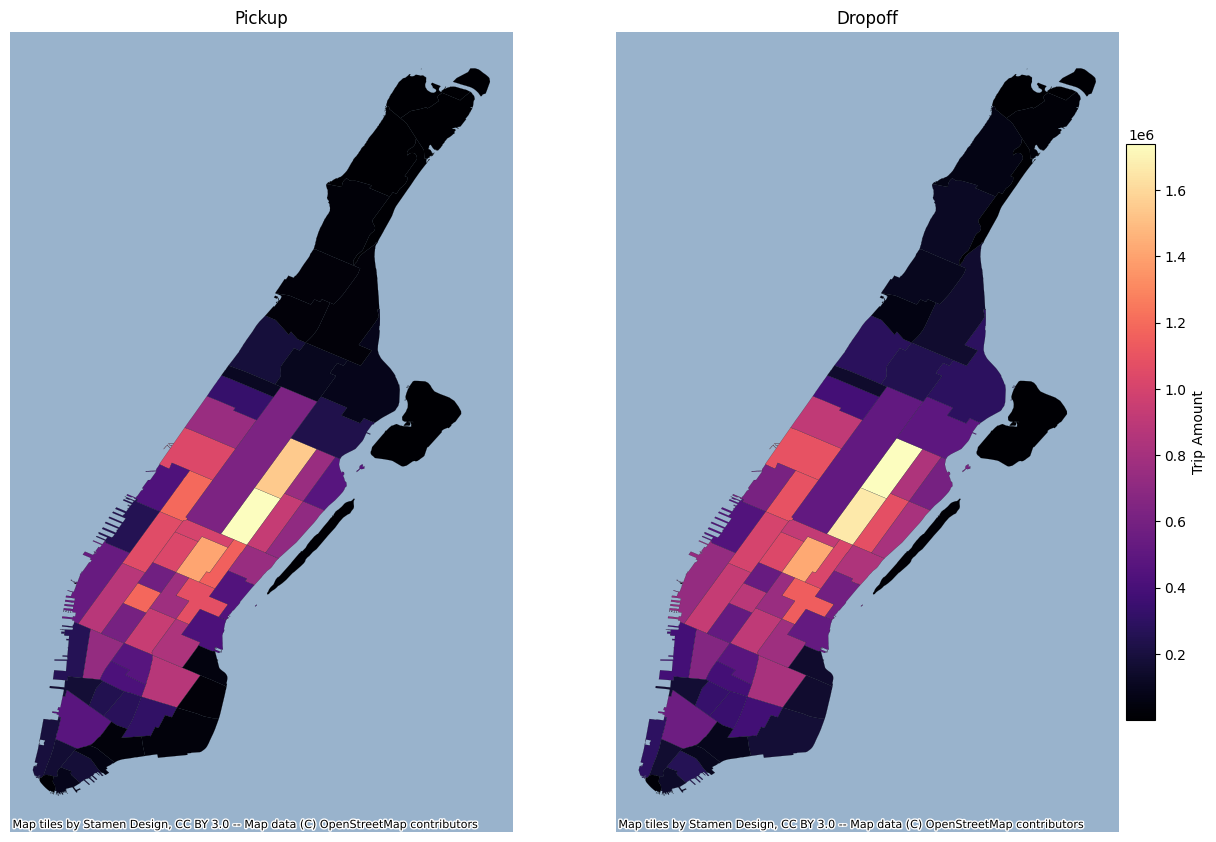

In [60]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 10))
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.09, right=0.8, wspace=0.02, hspace=0.02)

# Shared plot parameters
plot_params = {
    'linewidth': 0.1,
    'edgecolor': 'k',
    'cmap': 'magma',
    'legend': False,
}

# Data, titles, and axes for the plots
data = [(pu_zone, axs[0], 'Pickup'), (do_zone, axs[1], 'Dropoff')]

for zone_data, ax, title in data:
    vmin, vmax = zone_data['size'].min(), zone_data['size'].max()
    ax = zone_data.plot(column='size', norm=colors.Normalize(vmin=vmin, vmax=vmax), ax=ax, **plot_params)
    ctx.add_basemap(ax)
    ax.set_title(title)
    ax.set_axis_off()

# draw the color bar
patch_col = axs[0].collections[0]
cb = fig.colorbar(patch_col, ax=axs, shrink=0.72, orientation="vertical", pad=0.005)
cb.ax.set_ylabel('Trip Amount')
plt.show()


We can clearly see certain zones are hotspots so to speak for taxi pickups and drop-offs. This seems encouraging in terms of being able to predict busyness for a particular area.